In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
from scipy import stats
from operator import itemgetter
from scipy.stats import sem
from scipy.stats import ks_2samp
from scipy.stats import probplot
from cloveFunctions import *
import statsmodels.api as sm
import statsmodels.stats.power as smp
import pylab
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import warnings
warnings.filterwarnings('ignore')

In [4]:
memberships = pd.read_pickle('genesinmods.pickle')

In [15]:
celldf = pd.read_pickle('ccle_cell_info_df.pickle')
labels = list(celldf['Site Primary'].value_counts().index)
sizes = list(celldf['Site Primary'].value_counts())

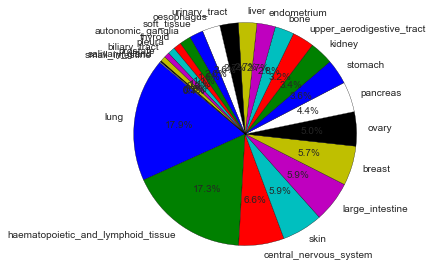

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# Data to plot
labels = list(celldf['Site Primary'].value_counts().index)
sizes = list(celldf['Site Primary'].value_counts())
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']     colors=colors,
# explode = (0.1, 0, 0, 0)  # explode 1st slice      explode=explode,
 
# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
 
plt.axis('equal')
plt.show()

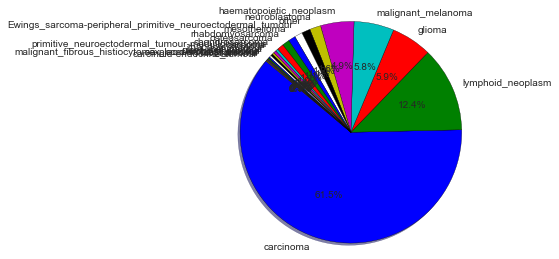

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# Data to plot
labels = list(celldf['Histology'].value_counts().index)
sizes = list(celldf['Histology'].value_counts())
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']     colors=colors,
# explode = (0.1, 0, 0, 0)  # explode 1st slice      explode=explode,
 
# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [23]:
ttest_00 = stack_process('tissueDF_ttest_cat.pickle', score='t-stat', diff='hyp')
ttest_75 = stack_process('tissueDF_ttest_cat_75.pickle', score='t-stat', diff='hyp')
pear_00 = stack_process('tissueDF_pearson_cat.pickle', score='pearson', diff='same_group')
pear_75 = stack_process('tissueDF_pearson_cat_75.pickle', score='pearson', diff='same_group')

In [24]:
ttest_00 = get_common(ttest_00)
ttest_75 = get_common(ttest_75)
pear_00 = get_common(pear_00)
pear_75 = get_common(pear_75)


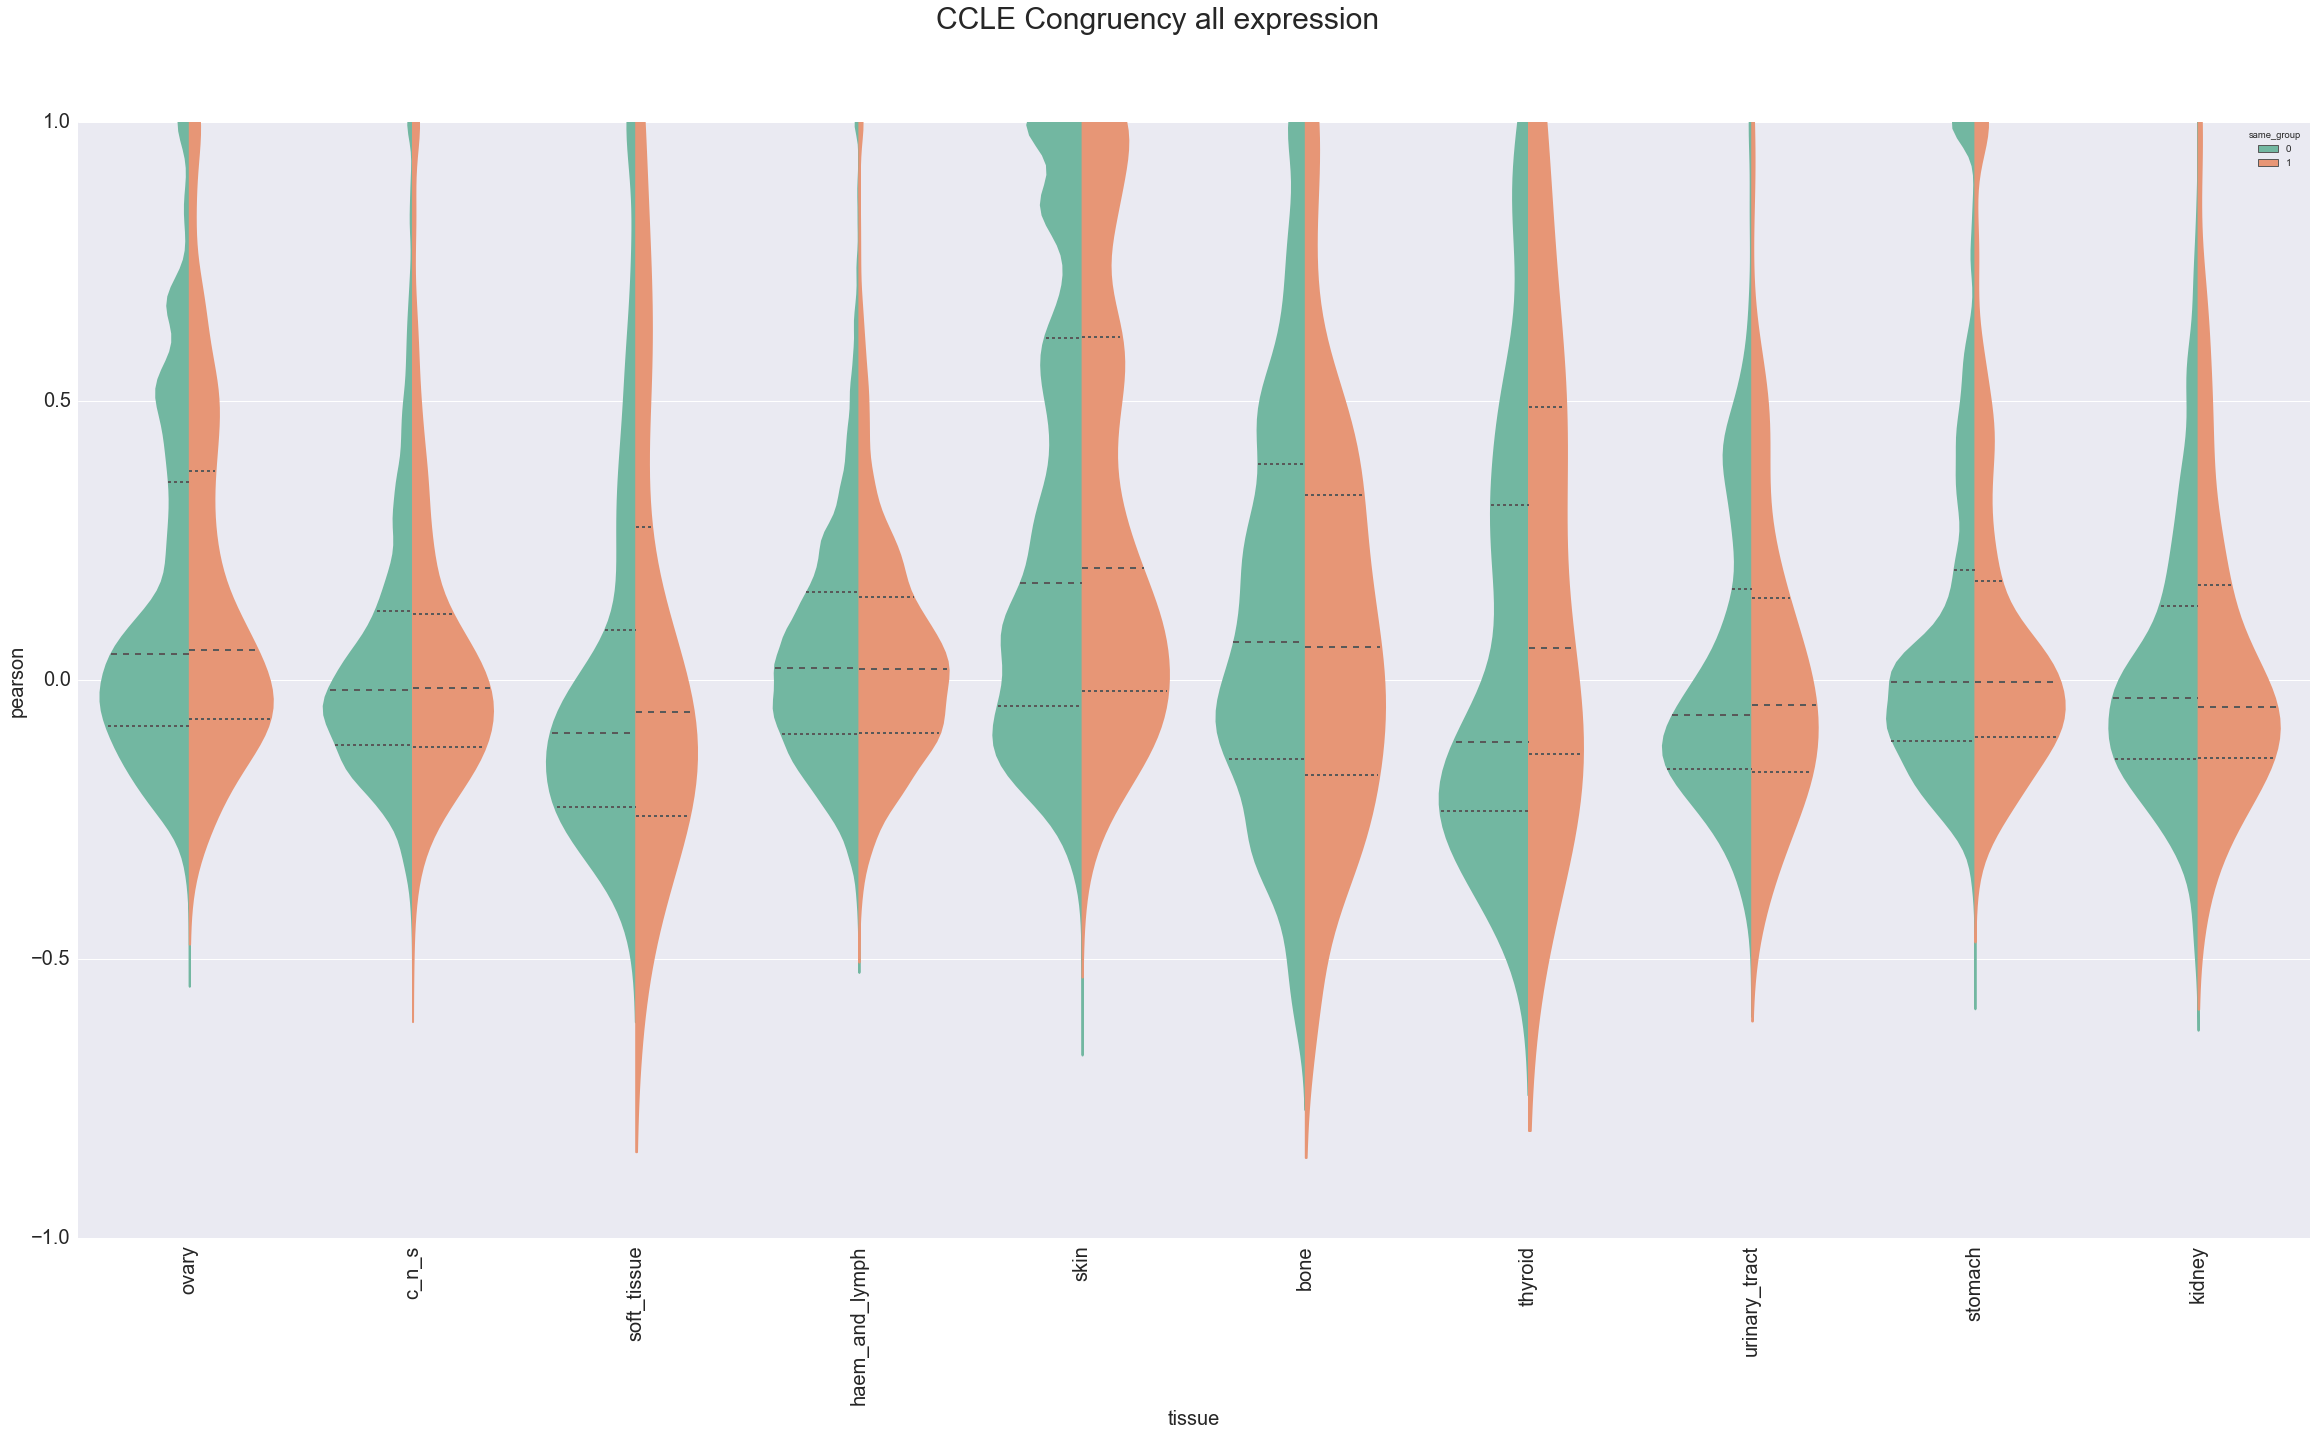

In [28]:
plot_violin(pear_00[pear_00['tissue'] != 'prostate'], title_='CCLE Congruency all expression')

In [29]:
ss_00 = summary_sort(pear_00, by_col='tissue', score='pearson', group='same_group')
ss_00.sort_values('t_Tstat', ascending=False)

,tissue,t_Tstat,t_Pval,ks_Dval,ks_Pval
5,skin,3.527598,0.000420,0.065079,0.000001
7,ovary,2.267077,0.023395,0.038058,0.014504
1,thyroid,1.975543,0.049015,0.237585,0.113150
10,c_n_s,1.454889,0.145709,0.017161,0.549347
6,kidney,1.253596,0.210109,0.052000,0.692186
2,soft_tissue,1.245331,0.213324,0.126217,0.201307
0,prostate,0.872318,0.388241,0.900000,0.035078
3,urinary_tract,-0.406956,0.684082,0.081380,0.363595
8,stomach,-0.667842,0.504238,0.033098,0.003202
4,bone,-1.207229,0.227419,0.069482,0.264941


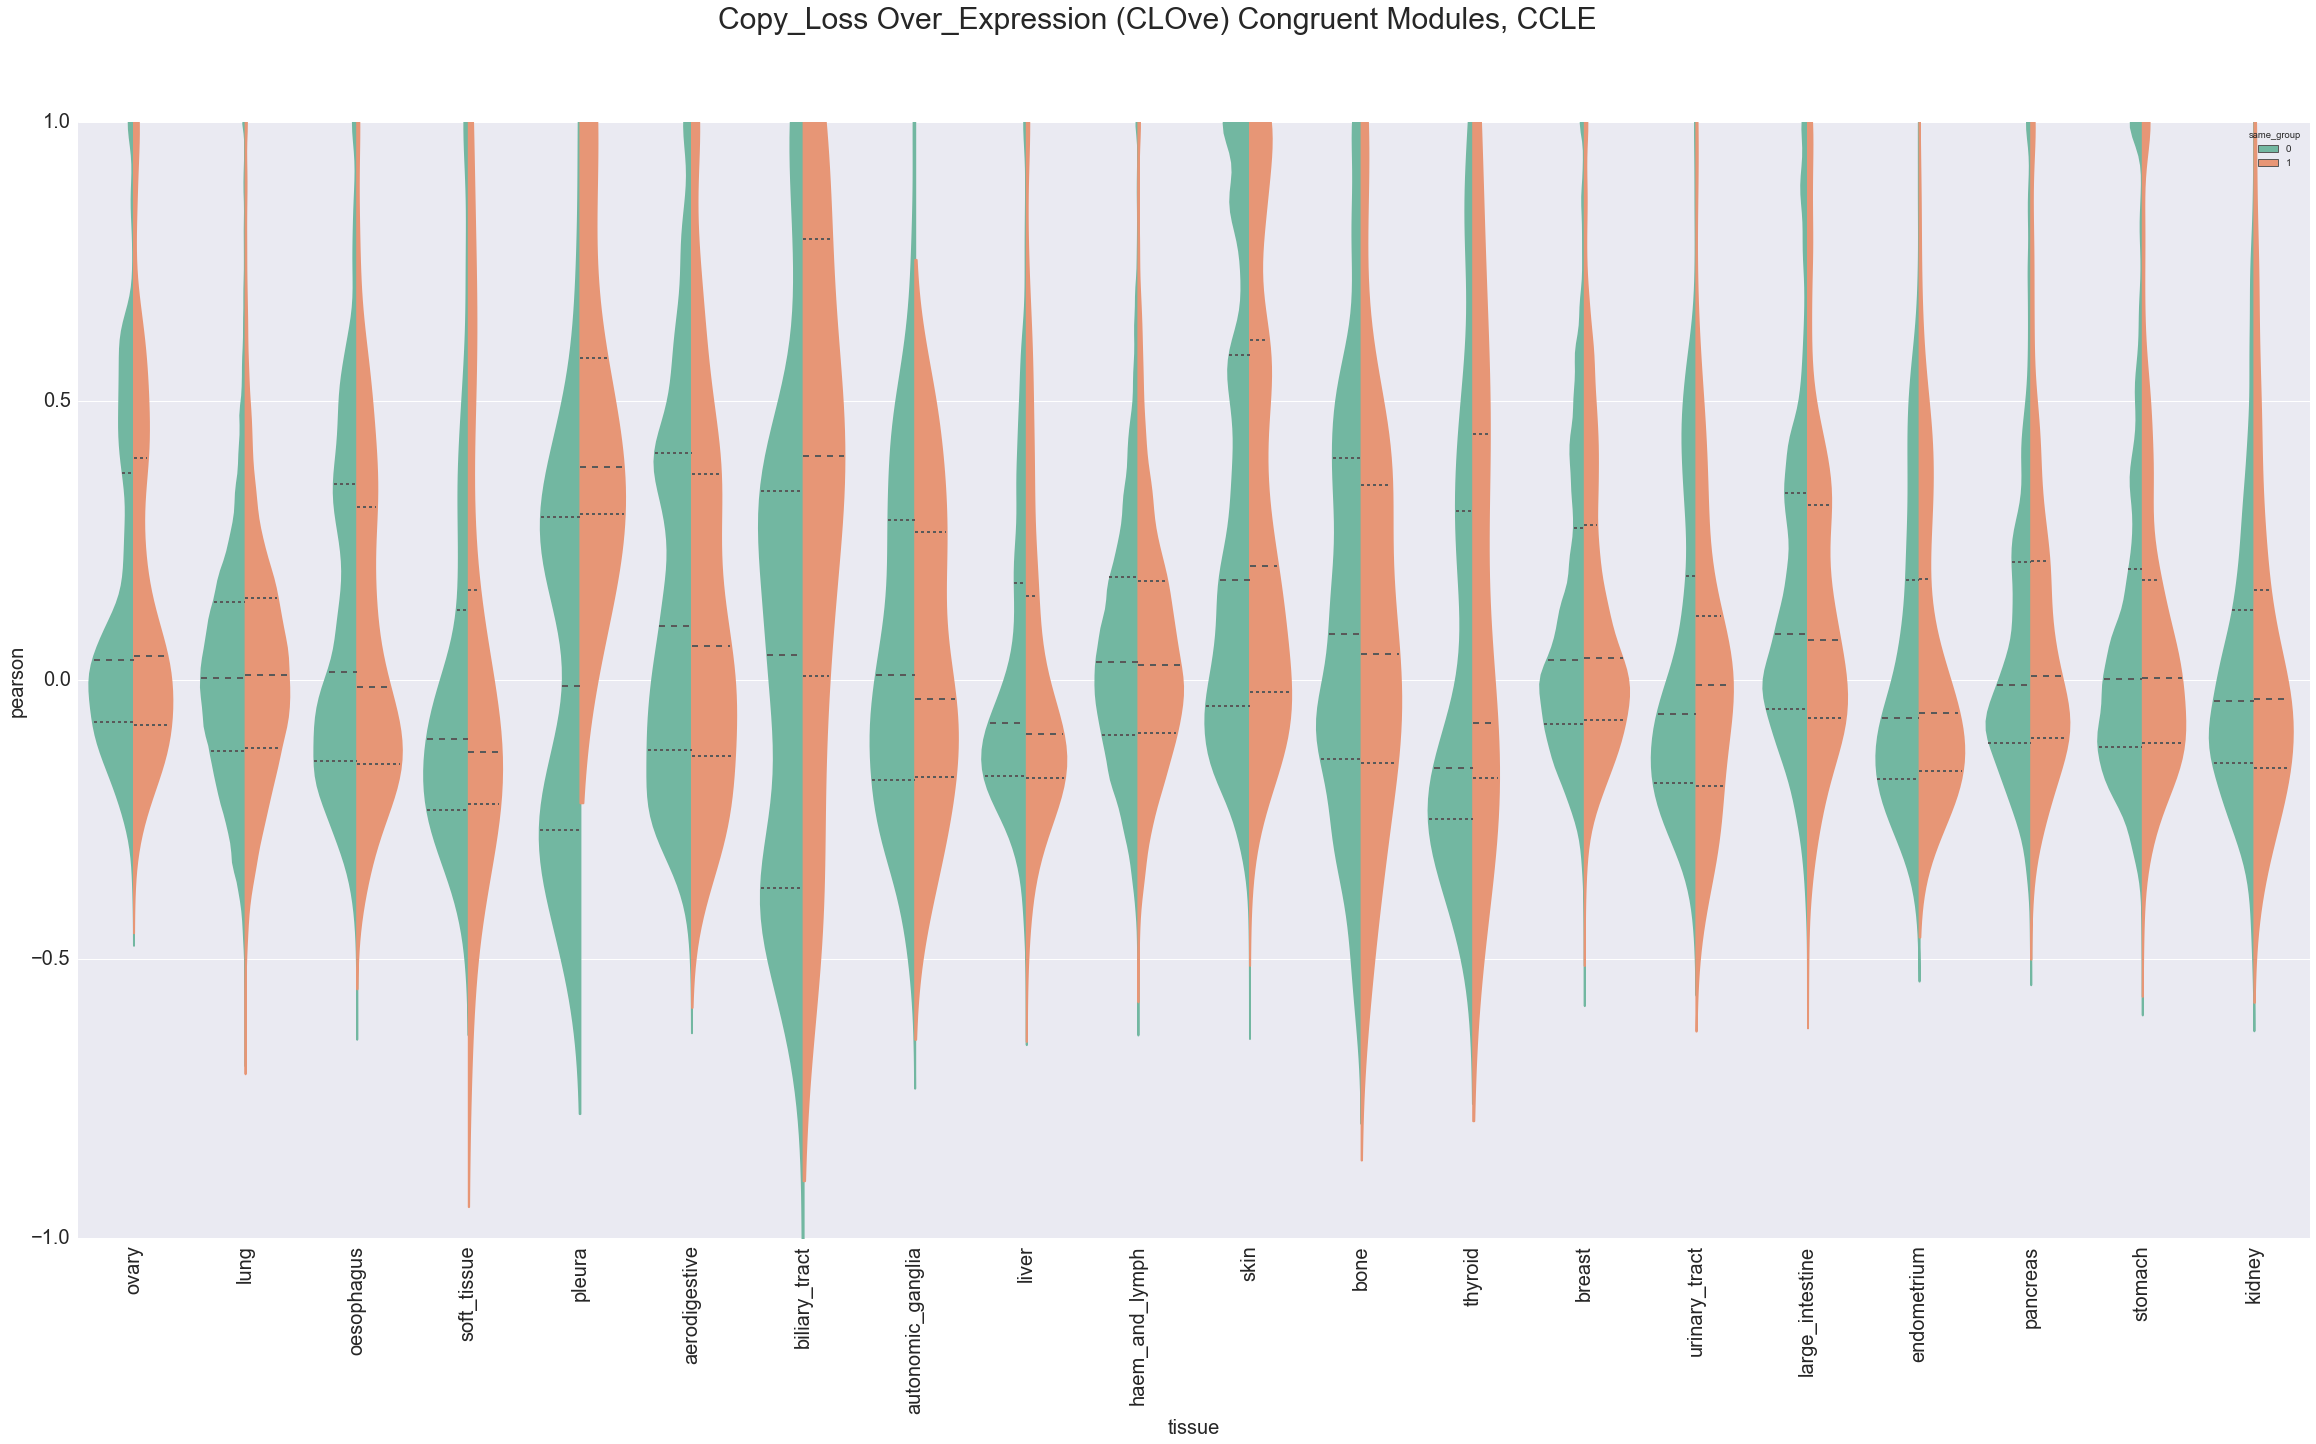

In [30]:
plot_violin(pear_75[pear_75['tissue'] != 'prostate'], title_='Copy_Loss Over_Expression (CLOve) Congruent Modules, CCLE')

In [31]:
ss_75 = summary_sort(pear_75[pear_75['tissue'] != 'prostate'], by_col='tissue', score='pearson', group='same_group')
ss_75.sort_values('ks_Dval', ascending=False)

,tissue,t_Tstat,t_Pval,ks_Dval,ks_Pval
0,pleura,3.770206,0.000232,0.594595,4.919195e-03
1,biliary_tract,3.547042,0.000439,0.386364,1.075188e-05
2,thyroid,1.960431,0.050762,0.282863,3.412125e-02
3,urinary_tract,-0.651646,0.514702,0.127652,3.060753e-02
4,soft_tissue,0.719823,0.471815,0.126217,2.013067e-01
5,endometrium,0.146547,0.883511,0.085370,1.929280e-01
6,autonomic_ganglia,-0.203523,0.838786,0.084144,8.432206e-01
7,bone,-1.123083,0.261474,0.081071,1.279840e-01
8,kidney,1.216971,0.223733,0.064222,4.229355e-01
9,oesophagus,-3.330893,0.000867,0.058084,7.116544e-04


In [32]:
ss_75

,tissue,t_Tstat,t_Pval,ks_Dval,ks_Pval
0,pleura,3.770206,0.000232,0.594595,4.919195e-03
1,biliary_tract,3.547042,0.000439,0.386364,1.075188e-05
2,thyroid,1.960431,0.050762,0.282863,3.412125e-02
3,urinary_tract,-0.651646,0.514702,0.127652,3.060753e-02
4,soft_tissue,0.719823,0.471815,0.126217,2.013067e-01
5,endometrium,0.146547,0.883511,0.085370,1.929280e-01
6,autonomic_ganglia,-0.203523,0.838786,0.084144,8.432206e-01
7,bone,-1.123083,0.261474,0.081071,1.279840e-01
8,kidney,1.216971,0.223733,0.064222,4.229355e-01
9,oesophagus,-3.330893,0.000867,0.058084,7.116544e-04


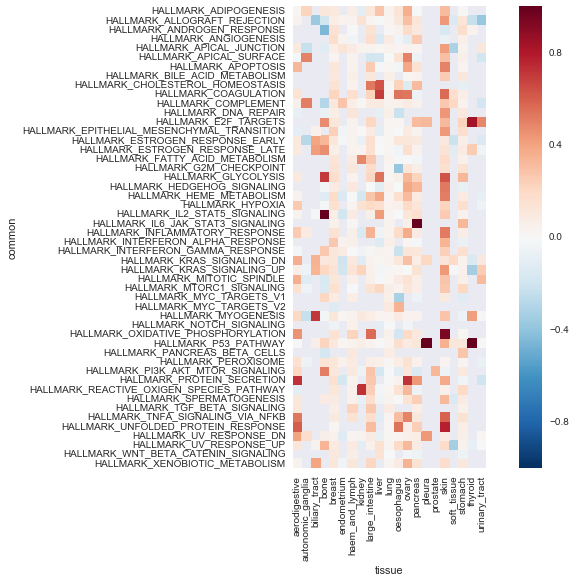

In [34]:
%matplotlib inline
dfp = unpack_pivot(pear_75)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(dfp, square=True)

In [35]:
ttest_75 = stack_process(ttest_75)
ttest_75 = get_common(ttest_75)

TypeError: invalid file:           mrna      cnv    t-stat  hyp        tissue  \
0         AARS      AGL  0.504536    0  kidney_ttest   
1         AARS    ATG10 -0.321347    0  kidney_ttest   
2         AARS    CADM2  0.117689    0  kidney_ttest   
3         AARS    CDH13  1.821627    0  kidney_ttest   
4         AARS   CDKN2A  1.113702    1  kidney_ttest   
5         AARS   CDKN2B  0.493212    0  kidney_ttest   
6         AARS   COL4A2 -1.453320    0  kidney_ttest   
7         AARS   COX4I1  1.063704    0  kidney_ttest   
8         AARS    CROCC  0.722570    0  kidney_ttest   
9         AARS      DCC  0.141545    0  kidney_ttest   
10        AARS     DLC1 -0.556167    0  kidney_ttest   
11        AARS    FBLN5 -0.156308    0  kidney_ttest   
12        AARS    GNA14 -0.144055    0  kidney_ttest   
13        AARS     GPHN  1.698016    0  kidney_ttest   
14        AARS     GRM8 -0.264887    0  kidney_ttest   
15        AARS    HIF1A  0.161922    1  kidney_ttest   
16        AARS    IMPA2 -1.209615    0  kidney_ttest   
17        AARS     IRF8  2.374192    1  kidney_ttest   
18        AARS     JAK2 -0.088079    1  kidney_ttest   
19        AARS     KAZN -0.945627    0  kidney_ttest   
20        AARS    LTBP1  1.399769    0  kidney_ttest   
21        AARS    MAGI2 -0.378720    0  kidney_ttest   
22        AARS   MAPK10  1.318373    0  kidney_ttest   
23        AARS    MYOM2  1.210617    0  kidney_ttest   
24        AARS    NCOA7 -0.706035    0  kidney_ttest   
25        AARS    NEGR1 -0.185044    0  kidney_ttest   
26        AARS      NF2  0.636249    0  kidney_ttest   
27        AARS      NTM -0.486801    0  kidney_ttest   
28        AARS    PARK2 -0.058271    0  kidney_ttest   
29        AARS    PDE4B  0.575504    0  kidney_ttest   
...        ...      ...       ...  ...           ...   
837575  FAM46A    PTPRD -2.925781    0    skin_ttest   
837576  FAM46A      PTS -1.445398    0    skin_ttest   
837577  FAM46A    PVRL1 -1.831638    0    skin_ttest   
837578  FAM46A     RCL1 -1.831638    0    skin_ttest   
837579  FAM46A      RHD  0.026093    0    skin_ttest   
837580  FAM46A  RPS6KA2 -1.910357    0    skin_ttest   
837581  FAM46A    SC5DL -1.831638    0    skin_ttest   
837582  FAM46A     SDHD -1.445398    0    skin_ttest   
837583  FAM46A   SH3GL2  0.193903    0    skin_ttest   
837584  FAM46A  SHROOM2  0.559036    0    skin_ttest   
837585  FAM46A    SIDT2 -1.831638    0    skin_ttest   
837586  FAM46A   SLC1A1 -1.831638    0    skin_ttest   
837587  FAM46A  SLC37A4 -1.831638    0    skin_ttest   
837588  FAM46A     SRPR -1.831638    0    skin_ttest   
837589  FAM46A     ST14 -1.831638    0    skin_ttest   
837590  FAM46A  ST3GAL4 -1.831638    0    skin_ttest   
837591  FAM46A    TAGLN -1.831638    0    skin_ttest   
837592  FAM46A    TFDP1  1.393997    0    skin_ttest   
837593  FAM46A   TGFBR3 -1.361124    0    skin_ttest   
837594  FAM46A     THY1 -1.831638    0    skin_ttest   
837595  FAM46A   TIMM8B -1.445398    0    skin_ttest   
837596  FAM46A   TRIM29 -1.831638    0    skin_ttest   
837597  FAM46A    TSTA3 -1.615511    0    skin_ttest   
837598  FAM46A   TXNRD1  0.067049    0    skin_ttest   
837599  FAM46A  UGT2B17  1.992187    0    skin_ttest   
837600  FAM46A    UNC5C -0.264358    0    skin_ttest   
837601  FAM46A    VLDLR -1.831638    0    skin_ttest   
837602  FAM46A    VWA5A -1.831638    0    skin_ttest   
837603  FAM46A   ZBTB16 -1.445398    0    skin_ttest   
837604  FAM46A     ZW10 -1.445398    0    skin_ttest   

                                   mrna_mods  \
0             [HALLMARK_ALLOGRAFT_REJECTION]   
1             [HALLMARK_ALLOGRAFT_REJECTION]   
2             [HALLMARK_ALLOGRAFT_REJECTION]   
3             [HALLMARK_ALLOGRAFT_REJECTION]   
4             [HALLMARK_ALLOGRAFT_REJECTION]   
5             [HALLMARK_ALLOGRAFT_REJECTION]   
6             [HALLMARK_ALLOGRAFT_REJECTION]   
7             [HALLMARK_ALLOGRAFT_REJECTION]   
8             [HALLMARK_ALLOGRAFT_REJECTION]   
9             [HALLMARK_ALLOGRAFT_REJECTION]   
10            [HALLMARK_ALLOGRAFT_REJECTION]   
11            [HALLMARK_ALLOGRAFT_REJECTION]   
12            [HALLMARK_ALLOGRAFT_REJECTION]   
13            [HALLMARK_ALLOGRAFT_REJECTION]   
14            [HALLMARK_ALLOGRAFT_REJECTION]   
15            [HALLMARK_ALLOGRAFT_REJECTION]   
16            [HALLMARK_ALLOGRAFT_REJECTION]   
17            [HALLMARK_ALLOGRAFT_REJECTION]   
18            [HALLMARK_ALLOGRAFT_REJECTION]   
19            [HALLMARK_ALLOGRAFT_REJECTION]   
20            [HALLMARK_ALLOGRAFT_REJECTION]   
21            [HALLMARK_ALLOGRAFT_REJECTION]   
22            [HALLMARK_ALLOGRAFT_REJECTION]   
23            [HALLMARK_ALLOGRAFT_REJECTION]   
24            [HALLMARK_ALLOGRAFT_REJECTION]   
25            [HALLMARK_ALLOGRAFT_REJECTION]   
26            [HALLMARK_ALLOGRAFT_REJECTION]   
27            [HALLMARK_ALLOGRAFT_REJECTION]   
28            [HALLMARK_ALLOGRAFT_REJECTION]   
29            [HALLMARK_ALLOGRAFT_REJECTION]   
...                                      ...   
837575  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837576  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837577  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837578  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837579  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837580  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837581  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837582  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837583  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837584  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837585  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837586  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837587  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837588  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837589  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837590  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837591  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837592  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837593  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837594  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837595  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837596  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837597  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837598  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837599  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837600  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837601  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837602  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837603  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
837604  [HALLMARK_INTERFERON_ALPHA_RESPONSE]   

                                                 cnv_mods  \
0              [HALLMARK_MYOGENESIS, HALLMARK_GLYCOLYSIS]   
1                            [HALLMARK_KRAS_SIGNALING_UP]   
2                              [HALLMARK_APICAL_JUNCTION]   
3       [HALLMARK_MYOGENESIS, HALLMARK_P53_PATHWAY, HA...   
4       [HALLMARK_E2F_TARGETS, HALLMARK_ALLOGRAFT_REJE...   
5         [HALLMARK_UV_RESPONSE_UP, HALLMARK_P53_PATHWAY]   
6       [HALLMARK_MYOGENESIS, HALLMARK_COMPLEMENT, HAL...   
7                    [HALLMARK_OXIDATIVE_PHOSPHORYLATION]   
8                               [HALLMARK_APICAL_SURFACE]   
9       [HALLMARK_SPERMATOGENESIS, HALLMARK_KRAS_SIGNA...   
10      [HALLMARK_ESTROGEN_RESPONSE_EARLY, HALLMARK_UV...   
11      [HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION, H...   
12                     [HALLMARK_PI3K_AKT_MTOR_SIGNALING]   
13                                [HALLMARK_ADIPOGENESIS]   
14                             [HALLMARK_SPERMATOGENESIS]   
15      [HALLMARK_INTERFERON_GAMMA_RESPONSE, HALLMARK_...   
16                      [HALLMARK_ESTROGEN_RESPONSE_LATE]   
17      [HALLMARK_INTERFERON_GAMMA_RESPONSE, HALLMARK_...   
18      [HALLMARK_INTERFERON_GAMMA_RESPONSE, HALLMARK_...   
19                     [HALLMARK_ESTROGEN_RESPONSE_EARLY]   
20                              [HALLMARK_UV_RESPONSE_DN]   
21                              [HALLMARK_UV_RESPONSE_DN]   
22                     [HALLMARK_PI3K_AKT_MTOR_SIGNALING]   
23                                  [HALLMARK_MYOGENESIS]   
24                   [HALLMARK_INTERFERON_ALPHA_RESPONSE]   
25                             [HALLMARK_APICAL_JUNCTION]   
26      [HALLMARK_SPERMATOGENESIS, HALLMARK_APICAL_JUN...   
27           [HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION]   
28                           [HALLMARK_KRAS_SIGNALING_DN]   
29      [HALLMARK_INTERFERON_GAMMA_RESPONSE, HALLMARK_...   
...                                                   ...   
837575                          [HALLMARK_UV_RESPONSE_UP]   
837576  [HALLMARK_FATTY_ACID_METABOLISM, HALLMARK_XENO...   
837577                         [HALLMARK_APICAL_JUNCTION]   
837578  [HALLMARK_HEME_METABOLISM, HALLMARK_MYC_TARGET...   
837579                         [HALLMARK_HEME_METABOLISM]   
837580  [HALLMARK_ESTROGEN_RESPONSE_EARLY, HALLMARK_ES...   
837581  [HALLMARK_CHOLESTEROL_HOMEOSTASIS, HALLMARK_AP...   
837582  [HALLMARK_OXIDATIVE_PHOSPHORYLATION, HALLMARK_...   
837583                       [HALLMARK_PROTEIN_SECRETION]   
837584  [HALLMARK_APICAL_SURFACE, HALLMARK_MITOTIC_SPI...   
837585                         [HALLMARK_HEME_METABOLISM]   
837586                 [HALLMARK_ESTROGEN_RESPONSE_EARLY]   
837587  [HALLMARK_HYPOXIA, HALLMARK_GLYCOLYSIS, HALLMA...   
837588               [HALLMARK_UNFOLDED_PROTEIN_RESPONSE]   
837589  [HALLMARK_P53_PATHWAY, HALLMARK_ESTROGEN_RESPO...   
837590                     [HALLMARK_IL2_STAT5_SIGNALING]   
837591  [HALLMARK_MYOGENESIS, HALLMARK_EPITHELIAL_MESE...   
837592  [HALLMARK_G2M_CHECKPOINT, HALLMARK_MYC_TARGETS...   
837593  [HALLMARK_APOPTOSIS, HALLMARK_EPITHELIAL_MESEN...   
837594  [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_APICAL...   
837595               [HALLMARK_OXIDATIVE_PHOSPHORYLATION]   
837596                  [HALLMARK_ESTROGEN_RESPONSE_LATE]   
837597  [HALLMARK_GLYCOLYSIS, HALLMARK_ESTROGEN_RESPON...   
837598  [HALLMARK_MTORC1_SIGNALING, HALLMARK_REACTIVE_...   
837599  [HALLMARK_PEROXISOME, HALLMARK_KRAS_SIGNALING_DN]   
837600                      [HALLMARK_HEDGEHOG_SIGNALING]   
837601  [HALLMARK_HYPOXIA, HALLMARK_HEDGEHOG_SIGNALING...   
837602  [HALLMARK_P53_PATHWAY, HALLMARK_KRAS_SIGNALING...   
837603  [HALLMARK_P53_PATHWAY, HALLMARK_KRAS_SIGNALING...   
837604  [HALLMARK_E2F_TARGETS, HALLMARK_PROTEIN_SECRET...   

                                                 all_mods  \
0       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_MYOGEN...   
1       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_KRAS_S...   
2       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_APICAL...   
3       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_MYOGEN...   
4       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_E2F_TA...   
5       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_UV_RES...   
6       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_MYOGEN...   
7       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_OXIDAT...   
8       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_APICAL...   
9       [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_SPERMA...   
10      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_ESTROG...   
11      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_EPITHE...   
12      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_PI3K_A...   
13      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_ADIPOG...   
14      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_SPERMA...   
15      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_INTERF...   
16      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_ESTROG...   
17      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_INTERF...   
18      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_INTERF...   
19      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_ESTROG...   
20      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_UV_RES...   
21      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_UV_RES...   
22      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_PI3K_A...   
23      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_MYOGEN...   
24      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_INTERF...   
25      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_APICAL...   
26      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_SPERMA...   
27      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_EPITHE...   
28      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_KRAS_S...   
29      [HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_INTERF...   
...                                                   ...   
837575  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837576  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837577  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837578  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837579  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837580  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837581  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837582  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837583  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837584  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837585  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837586  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837587  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837588  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837589  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837590  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837591  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837592  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837593  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837594  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837595  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837596  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837597  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837598  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837599  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837600  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837601  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837602  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837603  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   
837604  [HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_...   

                                common  
0                                   {}  
1                                   {}  
2                                   {}  
3                                   {}  
4       {HALLMARK_ALLOGRAFT_REJECTION}  
5                                   {}  
6                                   {}  
7                                   {}  
8                                   {}  
9                                   {}  
10                                  {}  
11                                  {}  
12                                  {}  
13                                  {}  
14                                  {}  
15      {HALLMARK_ALLOGRAFT_REJECTION}  
16                                  {}  
17      {HALLMARK_ALLOGRAFT_REJECTION}  
18      {HALLMARK_ALLOGRAFT_REJECTION}  
19                                  {}  
20                                  {}  
21                                  {}  
22                                  {}  
23                                  {}  
24                                  {}  
25                                  {}  
26                                  {}  
27                                  {}  
28                                  {}  
29                                  {}  
...                                ...  
837575                              {}  
837576                              {}  
837577                              {}  
837578                              {}  
837579                              {}  
837580                              {}  
837581                              {}  
837582                              {}  
837583                              {}  
837584                              {}  
837585                              {}  
837586                              {}  
837587                              {}  
837588                              {}  
837589                              {}  
837590                              {}  
837591                              {}  
837592                              {}  
837593                              {}  
837594                              {}  
837595                              {}  
837596                              {}  
837597                              {}  
837598                              {}  
837599                              {}  
837600                              {}  
837601                              {}  
837602                              {}  
837603                              {}  
837604                              {}  

[837605 rows x 9 columns]

In [36]:
%matplotlib inline
# ax = sns.boxplot(x='same_group', y="score", data=cs_1) # plots box and wisker for same/notsame group
ax = sns.violinplot(x='tissue', y="pearson_coeff", hue="same_group?", data=cong, palette="Set2", inner='stick',split=True, linewidth=0.5)
for item in ax.get_xticklabels():
    item.set_rotation(90)

# ax.savefig("congruent_pearson_GSEA_violin.png")

NameError: name 'cong' is not defined

In [ ]:
plt.figure(figsize=(90,20))
%matplotlib inline
# ax = sns.boxplot(x='same_group', y="score", data=cs_1) # plots box and wisker for same/notsame group
ax = sns.boxplot(x='tissue', y="pearson_coeff", hue="same_group?", data=cong, palette="Set2", linewidth=0.5)
for item in ax.get_xticklabels():
    item.set_rotation(90)
fig = ax.get_figure()

fig.savefig("congruent_pearson_GSEA_box.png")

In [ ]:
ttest_75

In [ ]:
cong[(cong["tissue"] == 'skin') & (cong["pearson_coeff"] > 0.8)].sort_values('pearson_coeff')

EIF5A	TP53	0.556128
TP53	POLR2A	0.467947	1
ERBB2	AKT3	0.458971	1
PTEN	AKT3	0.183250	1


POLR2A: This gene encodes the largest subunit of RNA polymerase II, the polymerase responsible for synthesizing messenger RNA in eukaryotes.

EIF5A: mRNA-binding protein involved in translation elongation.


In [ ]:
cong[cong.cnv.str.contains("PRT") & cong["same_group?"] == 1].sort_values(by='pearson_coeff', ascending=False)

**Below lies truncated CLAmp congruencies** (c2)

In [40]:
# 1) bring in and process tab-style congruency DF
c2 = stack_process('tissueDF_pearson_cat.pickle', score='pearson', diff='same_group')

In [42]:
# 2) get common pathways for each pair (row in congruency DF)
c2 = get_common(c2)
c2.to_pickle('clamp/tissueDF_pearson_cat_MOD.pickle')

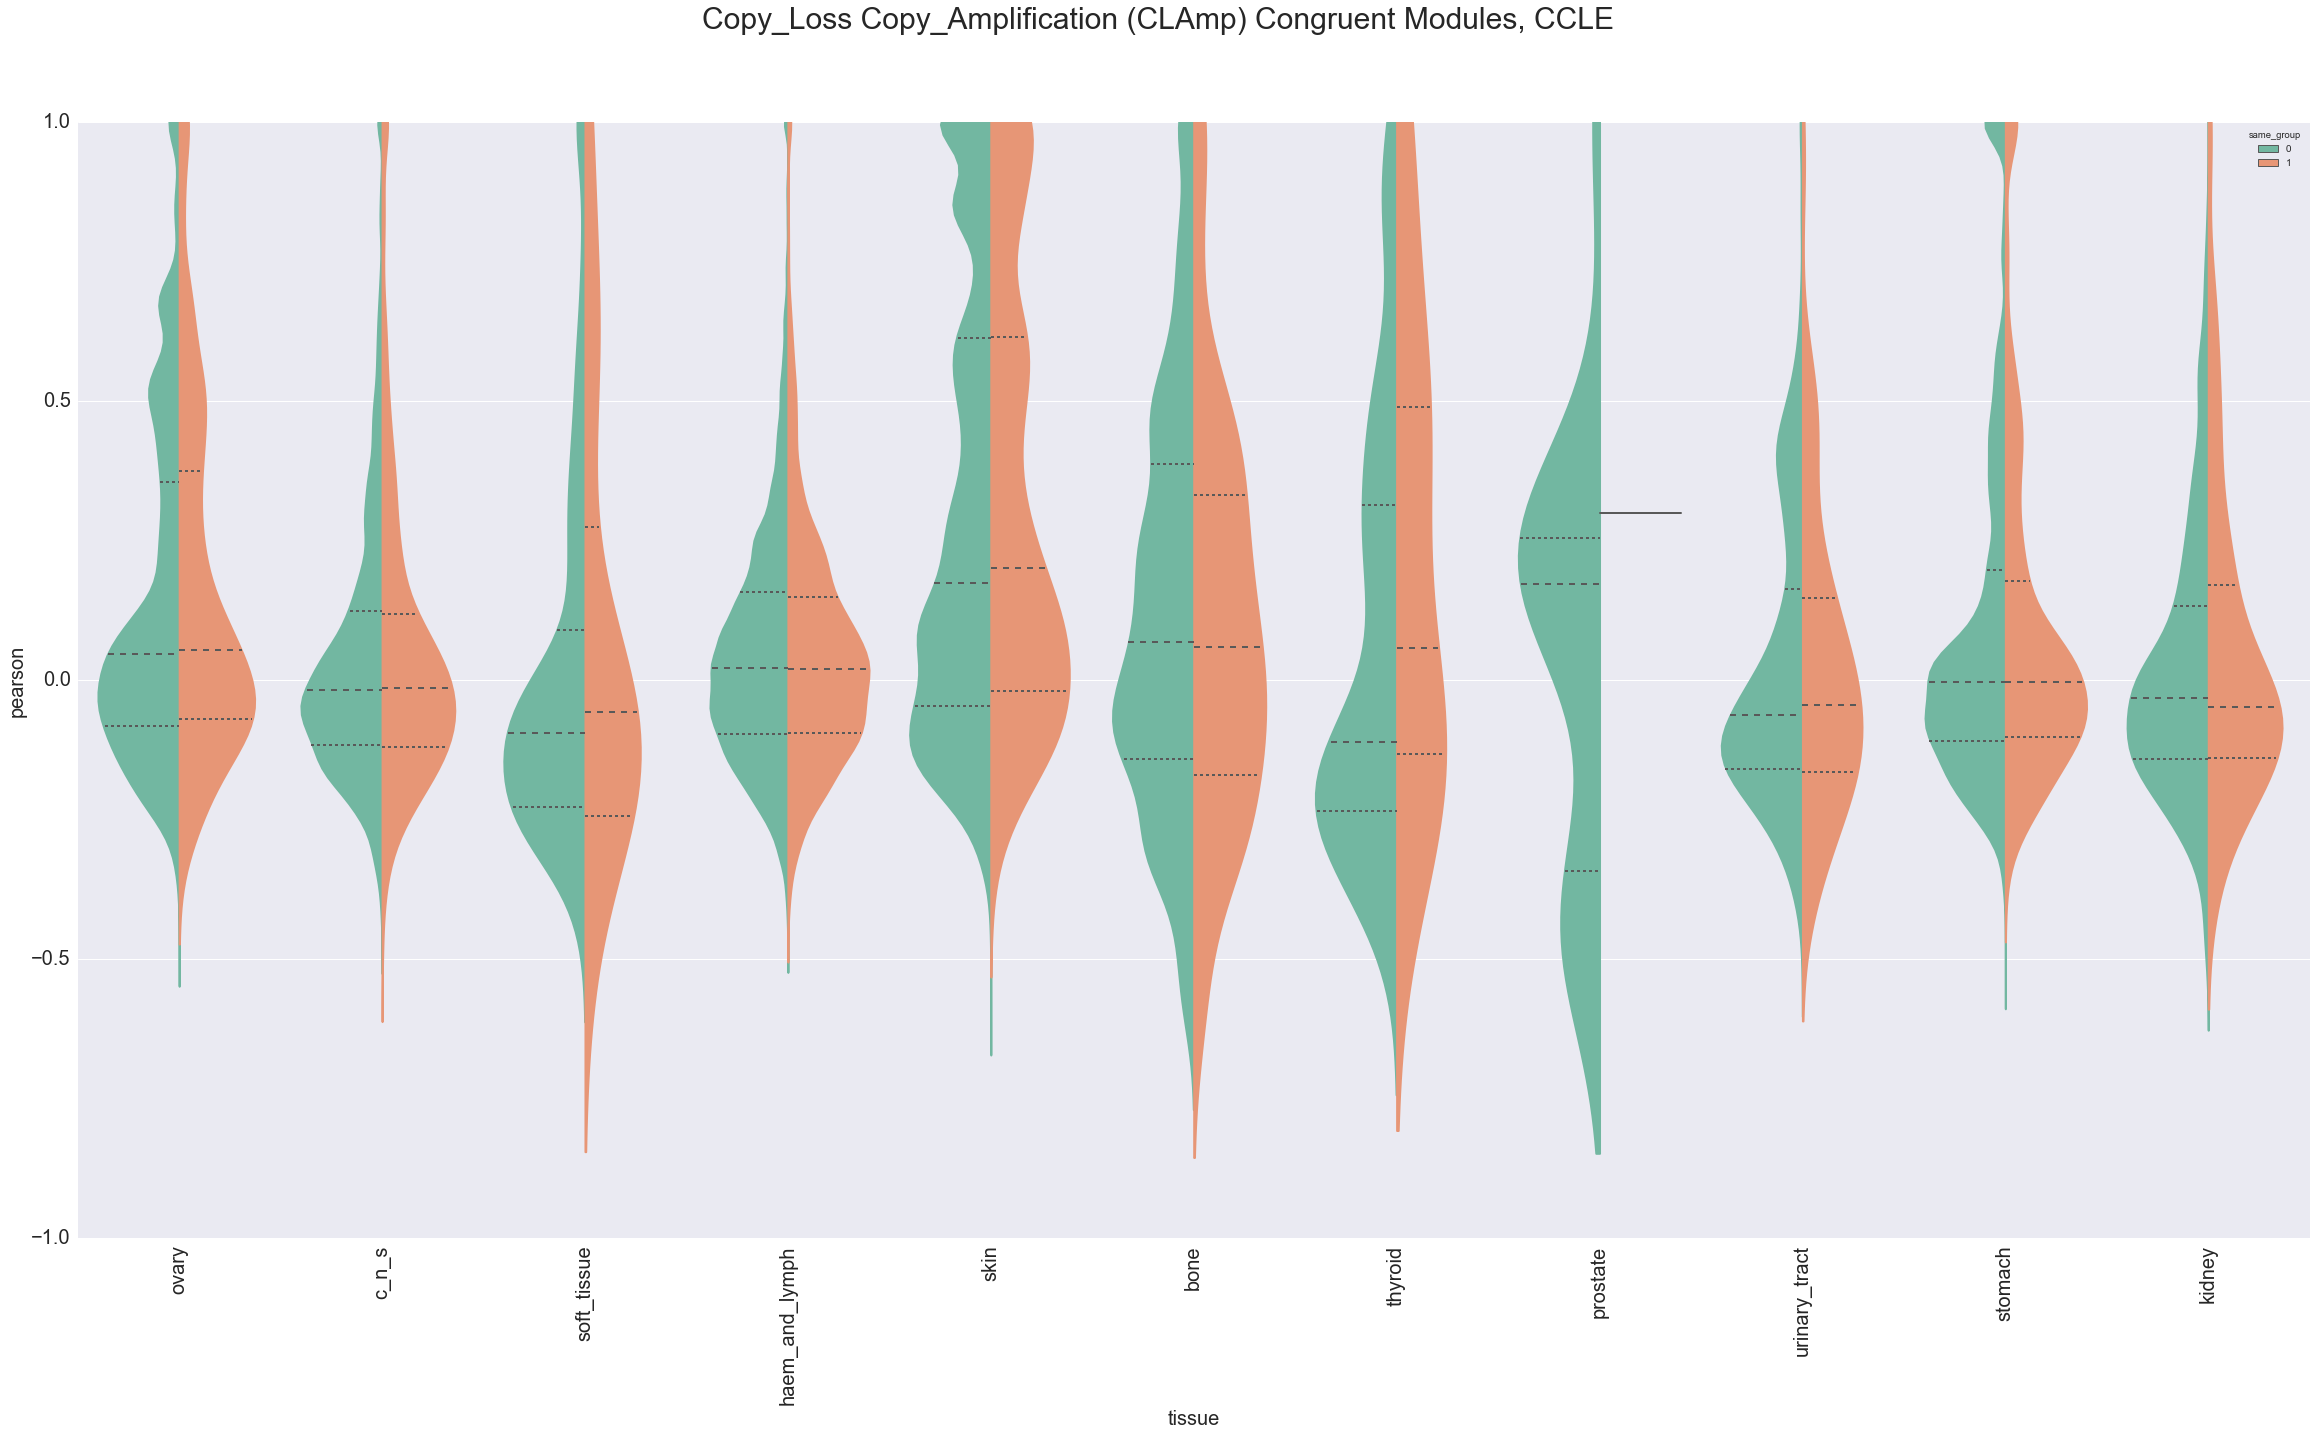

In [43]:
# 3) plot violin of in- vs out-group
plot_violin(c2, title_='Copy_Loss Copy_Amplification (CLAmp) Congruent Modules, CCLE')

In [44]:
ss_c2 = summary_sort(c2, by_col='tissue', score='pearson', group='same_group')

In [45]:
ss_c2.sort_values('ks_Dval', ascending=False)

,tissue,t_Tstat,t_Pval,ks_Dval,ks_Pval
0,prostate,0.872318,0.388241,0.900000,0.035078
1,thyroid,1.975543,0.049015,0.237585,0.113150
2,soft_tissue,1.245331,0.213324,0.126217,0.201307
3,urinary_tract,-0.406956,0.684082,0.081380,0.363595
4,bone,-1.207229,0.227419,0.069482,0.264941
5,skin,3.527598,0.000420,0.065079,0.000001
6,kidney,1.253596,0.210109,0.052000,0.692186
7,ovary,2.267077,0.023395,0.038058,0.014504
8,stomach,-0.667842,0.504238,0.033098,0.003202
9,haem_and_lymph,-1.475274,0.140141,0.017419,0.005390


In [ ]:
# 4) unpack 'common' set into duplicate rows of strings
# tissue common ks (pearson here)

%matplotlib inline
df = df[['tissue', 'common', 'pearson']]
df = df.groupby(['tissue','common']).mean().reset_index()
dfp = df.pivot( 'common', 'tissue','pearson')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(dfp, square=True)

In [ ]:
plot_violin(c2, title_='CCLE Congruency, CLAmp')

**Below lies comparison of CLAmp (c2) t-statistics with SynLethDB scores**

In [48]:
syndb = pd.read_pickle('synlethdb_sl_human.pickle')
breast = pd.read_pickle('clamp/c_tissueDF_ttest_stack_2/breast.pickle')

In [49]:
syndb_nn = syndb.dropna(how='any')

syndb_nn[syndb_nn['Species'].str.contains('breast')].GeneBSymbol.value_counts()
syndb_nn[(syndb_nn['Species'].str.contains('breast')) & syndb_nn['GeneBSymbol'].str.contains('MYC')]

,GeneASymbol,GeneAid,GeneBSymbol,GeneBid,PubmedID,Evidence,Type,Species,DiseaseScore
19870,CDK2,1017,MYC,4609,24444383;22430491,Text Mining;Synlethality,SL,breast cancer_D001943;Human triple-negative br...,0.832500
19868,CDK1,983,MYC,4609,24444383;25564254;22430491,Text Mining;Synlethality,SL,breast cancer_D001943;Human triple-negative br...,0.832500
18189,EIF4E,1977,MYC,4609,25564254;22573234;18327707;23803850,Text Mining,SL,cancer_D009369;tumor;breast carcinoma_D009369;...,0.560000
6780,CHEK1,1111,MYC,4609,22030621;21933891;25564254,Text Mining,SL,lymphoma;B-cell lymphomas;leukemia;neuroblasto...,0.430500
6739,BAG1,573,MYC,4609,21986497,Text Mining,SL,breast cancer_D001943,0.430500
6673,ATM,472,MYC,4609,22030621;21933891,Text Mining,SL,lymphoma;B-cell lymphomas;leukemia;neuroblasto...,0.273125
6656,BCL2L11,10018,MYC,4609,22430491;24444383,Text Mining,SL,breast cancer_D001943,0.273125
2645,CTNNBIP1,56998,MYC,4609,17005722,Text Mining,SL,colon cancer;breast cancer_D015179;D001943,0.177500
2443,BIRC2,329,MYC,4609,18327707,Text Mining,SL,breast carcinoma_D058922,0.177500
2445,FGF2,2247,MYC,4609,18327707,Text Mining,SL,breast carcinoma_D058922,0.177500


In [50]:
breast[(breast['cnv'].str.contains('MYC')) & breast['mrna'].str.contains('CDK')]

,cnv,mrna,t_stat,tissue,group
99498,MYC,CDK5R1,2.898179,breast,alt
99499,MYC,CDKN1B,-0.995950,breast,alt
99500,MYC,CDKN1C,-0.589589,breast,alt
99501,MYC,CDKN2A,-0.303905,breast,alt
99502,MYC,CDKN2AIP,0.207179,breast,alt
99503,MYC,CDKN2B,-0.059290,breast,alt


In [51]:
breast[(breast['cnv'].str.contains('BRCA')) & breast['mrna'].str.contains('PARP')]

,cnv,mrna,t_stat,tissue,group


In [52]:
syndb_nn[syndb_nn['Species'].str.contains('breast')].head(10)

,GeneASymbol,GeneAid,GeneBSymbol,GeneBid,PubmedID,Evidence,Type,Species,DiseaseScore
19837,BRCA1,672,PARP1,142,15829967;3965078;20832020;23370117;23564760;24...,Synlethality;Decipher;Text Mining,SL,"Human breast cancer;A549,PC3,MDA468;breast can...",0.990000
19951,EGFR,1956,NOTCH1,4851,20570903,Synlethality,SDL,Human Basal-like breast cancers (BLBC),0.900000
19939,NAMPT,10135,PARP2,10038,22933245,Synlethality,SL,triple negative breast cancers,0.855000
19886,BRCA2,675,PARP2,10038,15829967,Synlethality,SL,Human breast cancer,0.855000
19883,BRCA2,675,PARP1,142,21487248;18832051;16287996;24317580;20233726;2...,Synlethality;Text Mining,SL,Human cancer;breast cancer;deficiency of eithe...,0.850000
19873,ATM,472,PARP1,142,3965078;20832020;22030621;22101337;21603316;25...,Decipher;Text Mining,SL,"A549,PC3,MDA468;tumor vasculature;lymphoma;HR ...",0.850000
19871,EGFR,1956,PARP1,142,3965078;24954871;23071597;23564760,Decipher;Text Mining,SL,"A549,PC3,MDA468;non-small cell lung cancer;bre...",0.833594
19866,EGFR,1956,ERBB3,2065,20858866;20498641,Synlethality;Text Mining,SL,Human cancer;breast cancer_D001943,0.832500
19867,NAMPT,10135,PARP1,142,22933245,Synlethality;Text Mining,SL,Human triple-negative breast cancer;breast can...,0.832500
19870,CDK2,1017,MYC,4609,24444383;22430491,Text Mining;Synlethality,SL,breast cancer_D001943;Human triple-negative br...,0.832500


In [56]:
in_dir = 'clamp/c_tissueDF_ttest_stack_2/'
results = []
for filename in os.listdir('clamp/c_tissueDF_ttest_stack_2/'):
    if filename.endswith('.pickle'):

        tissue = filename.split('.pickle')[0]

        tissuedf = pd.read_pickle('clamp/c_tissueDF_ttest_stack_2/'+tissue+'.pickle')

        cols = ['gene_c', 'gene_m']

        df1 = tissuedf[['cnv', 'mrna', 't_stat']]
        df1.columns = cols + ['clamp']

        df2 = syndb[['GeneASymbol', 'GeneBSymbol', 'DiseaseScore']]
        df2.columns = cols + ['syndb']
        df2['gene_c'] = df2['gene_c'].astype(str)
        df2['gene_m'] = df2['gene_m'].astype(str)

        # sort the two id columns along the row
        df1[cols] = pd.np.sort(df1[cols], axis=1)
        df2[cols] = pd.np.sort(df2[cols], axis=1)

        # merge
        df3 = df1.merge(df2)
        tup = (tissue, *stats.pearsonr(df3['clamp'], df3['syndb']), *df3.shape)
        results.append(tup)
        if tissue == 'breast':
            breastdf = df3
        

C:\Users\test\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\test\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\test\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [57]:
sorted(results, key=itemgetter(3))

[('biliary_tract', nan, nan, 0, 4),
 ('bone', nan, nan, 0, 4),
 ('liver', nan, nan, 0, 4),
 ('pleura', nan, nan, 0, 4),
 ('prostate', nan, nan, 0, 4),
 ('salivary_gland', nan, nan, 0, 4),
 ('small_intestine', nan, nan, 0, 4),
 ('soft_tissue', nan, nan, 0, 4),
 ('thyroid', nan, nan, 0, 4),
 ('urinary_tract', nan, nan, 0, 4),
 ('autonomic_ganglia', nan, nan, 1, 4),
 ('endometrium', nan, nan, 2, 4),
 ('large_intestine', -0.091270381312329285, 0.75632443469287114, 14, 4),
 ('oesophagus', 0.15537247588862346, 0.58031362950087384, 15, 4),
 ('stomach', 0.37313061840971334, 0.11560979762210984, 19, 4),
 ('ovary', -0.089776150133700328, 0.70661887264780066, 20, 4),
 ('kidney', -0.32995535370327878, 0.14408852893308371, 21, 4),
 ('skin', 0.03460842256898311, 0.87847892531694771, 22, 4),
 ('pancreas', -0.4712186953227529, 0.023226575852368953, 23, 4),
 ('upper_aerodigestive_tract',
  -0.29992711970595642,
  0.1209845563379124,
  28,
  4),
 ('haematopoietic_and_lymphoid_tissue',
  0.04730026002619

C:\Users\test\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\test\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


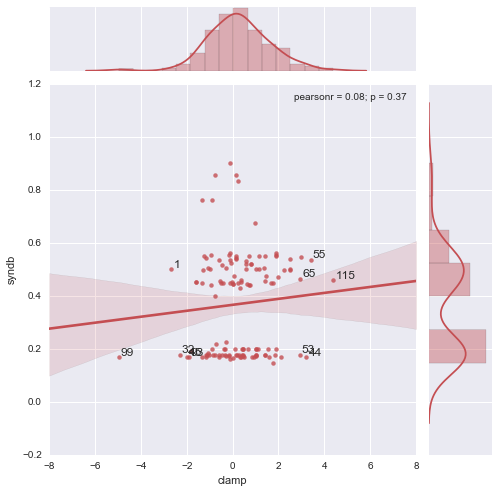

In [58]:
%matplotlib inline
sns.set(style="darkgrid", color_codes=True)

# sns.jointplot("clamp", "syndb", data=breastdf, kind="reg")

model = pd.ols(y=breastdf.clamp, x=breastdf.syndb)
breastdf['resid'] = model.resid

# xlim=(0, 60), ylim=(0, 12)
g = sns.jointplot("clamp", "syndb", data=breastdf, kind="reg", color="r", size=7)

#indices to annotate
head = breastdf.sort_values(by=['resid'], ascending=[False]).head(5)

tail = breastdf.sort_values(by=['resid'], ascending=[False]).tail(5)

def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["clamp"], r["syndb"]), 
            xytext=(2,2) , textcoords ="offset points", )

for row in head.iterrows():
    ann(row)
for row in tail.iterrows():
    ann(row)

plt.show()


In [59]:
pd.concat([head, tail])

,gene_c,gene_m,clamp,syndb,resid
115,HRAS,SDCCAG8,4.390598,0.4580,4.055543
44,LAMC2,PKP3,3.217000,0.1670,3.047182
55,CDH1,MYC,3.401331,0.5360,3.021987
53,BRCA1,MYC,2.930985,0.1775,2.755204
65,KCNIP2,MYC,2.944575,0.4640,2.606113
93,MAP3K7,POLR3C,-1.910761,0.1670,-2.080579
45,CTSB,LMNA,-1.983596,0.1670,-2.153414
32,ERBB2,TP53,-2.306017,0.1775,-2.481797
1,ABCB1,PTPRD,-2.668106,0.5000,-3.027009
99,CTSB,PTPN14,-4.958072,0.1670,-5.127890


In [60]:
breastdf.sort_values(by='clamp', ascending=False)

,gene_c,gene_m,clamp,syndb,resid
115,HRAS,SDCCAG8,4.390598,0.458000,4.055543
55,CDH1,MYC,3.401331,0.536000,3.021987
44,LAMC2,PKP3,3.217000,0.167000,3.047182
70,MYC,PTK2,2.977705,0.545000,2.593249
65,KCNIP2,MYC,2.944575,0.464000,2.606113
53,BRCA1,MYC,2.930985,0.177500,2.755204
74,MYC,SLC7A5,2.480680,0.539000,2.099632
63,IRF8,MYC,2.480680,0.500000,2.121777
57,CTCF,MYC,2.480680,0.497000,2.123481
69,MYC,PTEN,2.261074,0.497000,1.903875


** below lies the venn diagram info for CLAMP, CLOVE and maybe CLAMP > 0.8 cong and CLOVE > 0.8 cong **

In [61]:
clove_t = 5
clamp_t = 3

cols = ['mrna', 'cnv']

clove = pd.read_pickle('clove/tissueDF_ttest/breast.pickle').stack().reset_index()
clove.columns = ['mrna', 'cnv', 'ttest']
clove.replace([np.inf, -np.inf], np.nan, inplace=True)
clove.dropna(how="any", inplace=True)
clove[cols] = pd.np.sort(clove[cols], axis=1)
df = clove[clove['ttest'] > clove_t][cols]
df['cat'] = df['mrna'].astype(str) + " & " + df['cnv'].astype(str)
clove_s = df['cat'].tolist()

clamp = pd.read_pickle('clamp/tissueDF_ttest_2/breast.pickle').stack().reset_index()
clamp.columns = ['mrna', 'cnv', 'ttest']
clamp.replace([np.inf, -np.inf], np.nan, inplace=True)
clamp.dropna(how="any", inplace=True)
clamp[cols] = pd.np.sort(clamp[cols], axis=1)
df = clamp[clamp['ttest'] > clamp_t][cols]
df['cat'] = df['mrna'].astype(str) + " & " + df['cnv'].astype(str)
clamp_s = df['cat'].tolist()

clove total 1771877
clove only 1771075
clamp total 5995
clamp only 5193
intersect 802


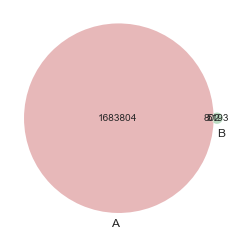

In [62]:
%matplotlib inline
from matplotlib_venn import venn2

intersect = set(clove_s).intersection(set(clamp_s))
print("clove total", len(clove_s))
print("clove only", len(clove_s)-len(intersect))
print("clamp total", len(clamp_s))
print("clamp only", len(clamp_s)-len(intersect))
print("intersect", len(intersect))

venn2([set(clove_s), set(clamp_s)])

In [63]:
# select some cloves
syndb = pd.read_pickle('synlethdb_sl_human.pickle')
cols = ['gene_c', 'gene_m']

df1 = clove[['cnv', 'mrna', 'ttest']]
df1.columns = cols + ['clove']

df2 = syndb[['GeneASymbol', 'GeneBSymbol', 'DiseaseScore']]
df2.columns = cols + ['syndb']
df2['gene_c'] = df2['gene_c'].astype(str)
df2['gene_m'] = df2['gene_m'].astype(str)

# sort the two id columns along the row
df1[cols] = pd.np.sort(df1[cols], axis=1)
df2[cols] = pd.np.sort(df2[cols], axis=1)

# merge
df3 = df1.merge(df2)
df3['cat'] = df3['gene_m'].astype(str) + " & " + df3['gene_c'].astype(str) + ":  " + df3['clove'].astype(str) 
df3.sort_values(by='clove', ascending=False, inplace=True)
df3_clove = df3.reindex_axis(['gene_c','gene_m','syndb','cat','clove'], axis=1)

C:\Users\test\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\test\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\test\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [64]:
df3_clove.sort_values(by='clove', ascending=False, inplace=True)
df3_clove[df3_clove['syndb'] > 0.7][['gene_c','gene_m','syndb','clove']]

,gene_c,gene_m,syndb,clove
1397,EGFR,SMAD2,0.8550,2.320706e+15
1398,EGFR,STAT3,0.8500,1.713955e+15
1386,BCAR1,EGFR,0.8550,1.713955e+15
588,BIRC5,HRAS,0.9000,1.443602e+15
1390,EGFR,NOTCH1,0.9000,9.895523e+14
1388,EGFR,FLNA,0.8550,9.895523e+14
1392,EGFR,PRKCD,0.8550,9.895523e+14
928,CDK1,MYC,0.8325,7.739861e+14
1447,EGFR,ERBB3,0.8325,7.249110e+14
1922,HRAS,PRKCD,0.8550,4.041077e+01


In [65]:
df3_clove.sort_values(by='syndb', ascending=False, inplace=True)
df3_clove[(df3_clove['clove'] > 2) & (df3_clove['clove'] < 11) & (df3_clove['syndb'] > 0.5
                                                                 )].sort_values(by='clove', ascending=False)

,gene_c,gene_m,syndb,cat,clove
1099,ABCB1,CHEK1,0.647,CHEK1 & ABCB1: 10.731189057,10.731189
1101,CHEK1,CMPK1,0.647,CMPK1 & CHEK1: 10.6650711617,10.665071
1110,CHEK1,RRM1,0.647,RRM1 & CHEK1: 10.5994526999,10.599453
1113,CHEK1,TYMS,0.647,TYMS & CHEK1: 10.5994526999,10.599453
1106,CHEK1,MRE11A,0.710,MRE11A & CHEK1: 10.5669006881,10.566901
852,CDA,CHEK1,0.647,CHEK1 & CDA: 10.5669006881,10.566901
1112,CHEK1,TP53,0.850,TP53 & CHEK1: 10.3772712095,10.377271
1460,ERCC1,RAD23B,0.545,RAD23B & ERCC1: 9.68652110807,9.686521
1456,ERCC1,POLD1,0.524,POLD1 & ERCC1: 9.68652110807,9.686521
1461,ERCC1,RAD51,0.536,RAD51 & ERCC1: 9.68652110807,9.686521


In [66]:
# select som clamps
syndb = pd.read_pickle('synlethdb_sl_human.pickle')
cols = ['gene_c', 'gene_m']

df1 = clamp[['cnv', 'mrna', 'ttest']]
df1.columns = cols + ['clamp']

df2 = syndb[['GeneASymbol', 'GeneBSymbol', 'DiseaseScore']]
df2.columns = cols + ['syndb']
df2['gene_c'] = df2['gene_c'].astype(str)
df2['gene_m'] = df2['gene_m'].astype(str)

# sort the two id columns along the row
df1[cols] = pd.np.sort(df1[cols], axis=1)
df2[cols] = pd.np.sort(df2[cols], axis=1)

# merge
df3 = df1.merge(df2)
df3['cat'] = df3['gene_m'].astype(str) + " & " + df3['gene_c'].astype(str)
df3.sort_values(by='clamp', ascending=False, inplace=True)
df3_clamp = df3.reindex_axis(['gene_c','gene_m','syndb','cat','clamp'], axis=1)

C:\Users\test\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\test\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\test\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [67]:
df3_clamp.sort_values(by='clamp', ascending=True, inplace=True)
df3_clamp[df3_clamp['clamp'] > 2.4][['gene_c','gene_m','syndb','clamp']]

,gene_c,gene_m,syndb,clamp
15,CAMK2B,SLC22A1,0.5300,2.418513
92,MYC,SLC7A5,0.5390,2.480680
75,CTCF,MYC,0.4970,2.480680
81,IRF8,MYC,0.5000,2.480680
71,BRCA1,MYC,0.1775,2.930985
83,KCNIP2,MYC,0.4640,2.944575
88,MYC,PTK2,0.5450,2.977705
59,LAMC2,PKP3,0.1670,3.217000
73,CDH1,MYC,0.5360,3.401331
142,HRAS,SDCCAG8,0.4580,4.390598


In [68]:
# select some intersections
syndb = pd.read_pickle('synlethdb_sl_human.pickle')

# merge
df3_int = df3_clamp.merge(df3_clove)
# df3['cat'] = df3['gene_m'].astype(str) + " & " + df3['gene_c'].astype(str)
# df3.sort_values(by='clamp', ascending=False, inplace=True)
# df3_clamp = df3.reindex_axis(['gene_c','gene_m','syndb','cat','clamp'], axis=1)


In [69]:
df3_int.sort_values(by='syndb', ascending=False)[(df3_int['clamp'] > 2) & (df3_int['clove'] > 2)]

,gene_c,gene_m,syndb,cat,clamp,clove


In [70]:
# congruent score for HRAS and/or SDCCAG8
cong_clamp = pd.read_pickle('clamp/tissueDF_pear_2/breast.pickle')
cong_clove = pd.read_pickle('clove/tissueDF_pear_1/breast_ttest.pickle')

In [71]:
cong_clove = pd.DataFrame(cong_clove.stack()).reset_index()
cong_clove.columns = ['gene_c', 'gene_m', 'clove']

cong_clamp = pd.DataFrame(cong_clamp.stack()).reset_index()
cong_clamp.columns = ['gene_c', 'gene_m', 'clamp']

In [72]:
cols = ['gene_c', 'gene_m']
cong_clove[cols] = pd.np.sort(cong_clove[cols], axis=1)
cong_clamp[cols] = pd.np.sort(cong_clamp[cols], axis=1)

In [73]:
cong_merge = cong_clove.merge(cong_clamp)

In [74]:
cong_merge[(cong_merge['gene_m'].str.contains('SDC')) & (cong_merge['gene_c'].str.contains('HRAS'))]

,gene_c,gene_m,clove,clamp
2311484,HRAS,SDC1,0.870802,0.460931
2311485,HRAS,SDC1,0.870802,0.460931
2311486,HRAS,SDC1,0.870802,0.460931
2311487,HRAS,SDC1,0.870802,0.460931
2311488,HRAS,SDC3,0.961380,0.463791
2311489,HRAS,SDC3,0.961380,0.463791
2311490,HRAS,SDC3,0.961380,0.463791
2311491,HRAS,SDC3,0.961380,0.463791


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027BEBE892B0>]], dtype=object)

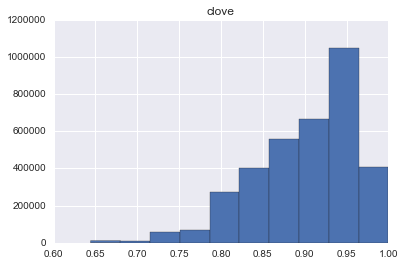

In [75]:
%matplotlib inline
pd.DataFrame.hist(cong_merge, 'clove')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027BECA8F588>]], dtype=object)

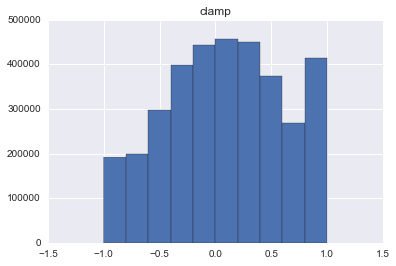

In [76]:
%matplotlib inline
pd.DataFrame.hist(cong_merge, 'clamp')

In [ ]:
%matplotlib inline
sns.distplot(cong_merge['clove'], rug=True, hist=False)


C:\Users\test\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [ ]:
%matplotlib inline

t = pd.read_pickle('clamp/tissueDF_ttest_2/breast.pickle').stack()
tdf = pd.DataFrame(t).reset_index()
tdf.columns = ['m_gene', 'c_gene', 't_stat']

plt.rcParams['figure.figsize']=(10,10)
tissue = tdf['t_stat']
null = pd.read_csv('report_null.csv').dropna(how='any')['t_stat']
sns.kdeplot(null, bw=1, label='null', shade=True)
sns.kdeplot(tissue, bw=.5, label='tissue', shade=True)
plt.ylabel('Frequency')
plt.xlabel('T-Statistic')
plt.title('CLAmp T-Statistics  '+ 'Breast Cell Lines')
plt.xlim([-5,8])
print(ks_2samp(null, tissue))

In [ ]:
%matplotlib inline

plt.rcParams['figure.figsize']=(10,10)
null = pd.read_csv('report_null.csv').dropna(how='any')['t_stat']
tissue = df3_clamp['clamp']
sns.kdeplot(null, bw=1, label='null', shade=True)
sns.kdeplot(tissue, bw=.5, label='tissue', shade=True)
sns.rugplot(df3_clove['syndb'], height=0.5, axis='s')
plt.ylabel('Frequency')
plt.xlabel('T-Statistic')
plt.title('CLOVe T-Statistics  '+ 'Breast Cell Lines')
plt.xlim([-5,8])
print(ks_2samp(null, tissue))

# x = np.random.randn(100)
# rug_array = np.array([-2.0, -1, 0, 1, 2, 2.1, 3])

# ax = sns.distplot(x, rug=False)
# sns.rugplot(rug_array, height=0.05, axis='x', ax=ax)

# plt.show()

In [ ]:
g = sns.jointplot("clove", "syndb", data=df3_clove, kind="kde", color="g")

In [ ]:

g = sns.jointplot("clamp", "syndb", data=df3_clamp, kind="reg", color="r", size=7)

In [ ]:
lo_clove = df3_clove[df3_clove['clove'] < -2.5]['syndb']
hi_clove = df3_clove[df3_clove['clove'] > -2.5]['syndb']

lo_clamp = df3_clamp[df3_clamp['clamp'] < -2.5]['syndb']
hi_clamp = df3_clamp[df3_clamp['clamp'] > -2.5]['syndb']

sns.distplot(lo_clove, rug=True, hist=False)
sns.distplot(hi_clove, rug=True, hist=False)
sns.distplot(lo_clamp, rug=True, hist=False)
sns.distplot(hi_clamp, rug=True, hist=False)

In [ ]:
# t4 = pd.read_csv('post_fdr_t4_revsor_p.tab', sep='\t')
t4 = pd.read_pickle('post_fdr_t4_revsor_p.pickle')

In [ ]:
t4.head(10)

In [ ]:
t4 = t4[t4['null'] == 0]
t4.set_index('idx', inplace=True, drop = True)
del t4['p_val']
del t4['null']

In [ ]:
t4 = pd.read_csv('post_fdr_t4_revsor_p.tab', sep='\t', index_col='idx')
t4 = t4[t4['null'] == 0]
del t4['p_val']
del t4['null']

In [ ]:
t4.to_hdf('post_fdr_t4_revsor_p_1.hdf','t4')

In [ ]:
# name = t4.link.str.split('&').apply(pd.Series)
# t4 = pd.merge(name, t4, left_index=True, right_index=True)
# t4.columns = ['link', 't_stat', 'cumu_fdr', 'bh_pval', 'exp', 'cnv']
# t4 = t4[['link', 'exp', 'cnv', 't_stat', 'cumu_fdr', 'bh_pval']]
# t4.cnv.value_counts().to_pickle('counts_cnv.p')
# t4.exp.value_counts().to_pickle('counts_exp.p')
# #mean score for pairs by cnv context

In [6]:
t4=pd.read_hdf('post_fdr_t4_revsor_p_1.hdf')
t4['t_stat'] = t4.t_stat.astype(np.float32, copy=False)
t4['cumu_fdr'] = t4.cumu_fdr.astype(np.float32, copy=False)
t4['bh_pval'] = t4.bh_pval.astype(np.float32, copy=False)

In [ ]:
t4.sort_values(by='t_stat').head(10)

In [ ]:
t4.info()

In [ ]:
t4.info()

In [ ]:
cnvcall = pd.read_pickle('CCLE_DEL_calls.pickle')
cnvdf = pd.read_pickle('cnvdf.pickle')

In [ ]:
cnvdf.dropna(how='all', inplace=True)
'LOC100190986' in cnvdf.index

In [ ]:
t4.head(10)

In [ ]:
t4[t4['link'].str.contains('DHRS7&MY')]

In [ ]:
t4[t4['link'].str.contains('BRCA') & t4['link'].str.contains('PARP')]

In [ ]:
t4[t4['link'].str.contains('BRCA') & t4['link'].str.contains('PARP')]

In [ ]:
dcall = pd.read_pickle('CCLE_DEL_calls.pickle')
dcall[dcall.ix['TACSTD2'] < 0]

In [ ]:
t4.join(t4['link'].str.split('&', 1, expand=True).rename(columns={0:'gene_1', 1:'gene_2'}))

In [ ]:
del t4['null']

In [ ]:
t4.head(10)

**FDR compare to t_stat, p_val**

In [ ]:
t0 = pd.read_pickle('post_fdr_t0_revsor_p.p')

In [ ]:
np.log10(5)

In [ ]:
t0['log_t'] = np.log10(t0['t_stat'])

In [ ]:
samp = t0.sample(10000)

In [ ]:
t0[t0['null'] == 1].t_stat.max()

In [ ]:
t0.head(3)

In [ ]:
samp = t0.sample(10000)

In [ ]:
dfx = t0[t0['null']==0].sample(1000)
print(dfx.shape)
dfy = t0[t0['null']==1].sample(1000)
print(dfy.shape)

In [ ]:
%matplotlib inline
f, ax = plt.subplots(figsize=(6, 6))

sns.kdeplot(dfx.log_t, dfy.log_t, ax=ax)
sns.rugplot(dfx.log_t, color="g", ax=ax)
sns.rugplot(dfy.log_t, vertical=True, ax=ax);

In [ ]:
%matplotlib inline
f, ax = plt.subplots(figsize=(6, 6))

sns.kdeplot(dfx.log_t, dfy.log_t, ax=ax)
sns.rugplot(dfx.log_t, color="g", ax=ax)
sns.rugplot(dfy.t_stat, vertical=True, ax=ax);

In [ ]:
%matplotlib inline
f, ax = plt.subplots(figsize=(6, 6))
ax.set(ylim=(-2, 0.5))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(dfx.log_t, dfy.log_t, cmap=cmap, n_levels=60, shade=True);

In [ ]:
fdr5 = t0[t0['cumu_fdr'] < 0.05]

In [ ]:
fdr5.sort_values(by='t_stat')

In [ ]:
fdr5.info()

In [ ]:
import seaborn as sns; sns.set(style="white", color_codes=True)


In [ ]:
%matplotlib inline
g = sns.jointplot(x='log_t', y='p_val', data=samp)

In [ ]:
%matplotlib inline
g = sns.jointplot(x='log_t', y='cumu_fdr', data=samp)

In [ ]:
island = t0[(t0['log_t'] > 10) & (t0['log_t'] < 18)]

In [ ]:
island.shape[0]

In [ ]:
t0[t0['log_t'] < 10].shape[0]

In [ ]:
%matplotlib inline
# simulate some artificial data
# ========================================
np.random.seed(0)
data1 = np.random.multivariate_normal([0,0], [[1,0.5],[0.5,1]], size=200)
data2 = np.random.multivariate_normal([0,0], [[1,-0.8],[-0.8,1]], size=100)

# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
df1 = samp[samp['null']==1]
df2 = samp[samp['null']==0]


# plot
# ========================================   
graph = sns.jointplot(x='log_t', y='cumu_fdr', data=samp)

graph.x = df2['log_t']
graph.y = df2['cumu_fdr']
graph.plot_joint(plt.scatter, c='g')

In [ ]:
%matplotlib inline
g = sns.jointplot(x='t_stat', y='cumu_fdr', data=t0)
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

In [ ]:
rmse = pd.read_pickle('results_rmse.p')
rmse['rmse_mean'] = rmse['rmse_out']/25

In [ ]:
rmse.head(10)

In [ ]:
%matplotlib inline
ax = sns.boxplot(x="rna", y="rmse_mean", orient='h', data=rmse)

In [ ]:
rmse_pivot = pd.read_pickle('rmse_pivot.p')

In [ ]:
rmse_pivot = rmse_pivot.transpose()

In [ ]:
pre_box = rmse_pivot.reindex_axis(rmse_pivot.mean().sort_values().index, axis=1)

In [ ]:
%matplotlib inline
g = sns.jointplot(x='t_stat', y='cumu_fdr', data=t0)

**50/50 Split single comparison**

In [ ]:
df = pd.read_hdf('madre_merge_sort32.h5', 'df')

**AR-Associated PARP inhibitor Sensitivity**

In [3]:
t0 = pd.read_pickle('post_fdr_t0_revsor_p.p')
t0.head(10)

,link,t_stat,p_val,null,cumu_fdr,bh_pval
79299165,RABGGTB&FAM118A,0.000004,0.999996,1,1.0,0.999996
79299164,ZDHHC13&TCERG1L,0.000008,0.999994,1,1.0,0.999994
79299163,L3MBTL2&LINC00462,0.000025,0.999980,1,1.0,0.999980
79299162,L3MBTL2&CYSLTR2,0.000025,0.999980,1,1.0,0.999980
79299161,DCAF4L1&CROCC,0.000025,0.999980,1,1.0,0.999980
79299160,REV3L&CADM2,0.000035,0.999972,1,1.0,0.999972
79299159,LOC100505938&LINC00305,0.000037,0.999971,1,1.0,0.999971
79299151,ERCC6L&RNF125,0.000038,0.999970,1,1.0,0.999970
79299144,ERCC6L&KLHL14,0.000038,0.999970,1,1.0,0.999970
79299145,ERCC6L&TTR,0.000038,0.999970,1,1.0,0.999970


In [4]:
adt_q = t0[t0['link'].str.contains("ADT")]

In [5]:
adt_q[adt_q['link'].str.contains("PARP")]

,link,t_stat,p_val,null,cumu_fdr,bh_pval
17165261,ADTRP&PARP3,1.666807e+15,0.0,0,0.013529,0.0
1825853,PARP1&ADTRP,1.970041e+15,0.0,0,0.012356,0.0


In [6]:
rad = t0[t0['link'].str.contains("RAD")]
h2ax = t0[t0['link'].str.contains("H2AX")]
atm = t0[t0['link'].str.contains("ATM")]
mre = t0[t0['link'].str.contains("MRE")]

In [7]:
rad51 = rad[rad['link'].str.contains("RAD51")]
rad51[rad51['link'].str.contains("PARP1")].sort_values(by='t_stat', ascending=False)

,link,t_stat,p_val,null,cumu_fdr,bh_pval
16439130,PARP14&RAD51D,2.283031e+15,0.000000e+00,0,0.013373,0.000000e+00
16439101,PARP14&RAD51L3-RFFL,2.283031e+15,0.000000e+00,0,0.013373,0.000000e+00
29530105,PARP14&RAD51B,1.318109e+15,0.000000e+00,0,0.016890,0.000000e+00
29530054,PARP14&RAD51C,1.318109e+15,0.000000e+00,0,0.016890,0.000000e+00
30835692,PARP1&RAD51,3.036891e+01,0.000000e+00,0,0.017346,0.000000e+00
30837744,PARP1&RAD51AP2,3.036891e+01,0.000000e+00,0,0.017346,0.000000e+00
39334124,PARP1&RAD51C,1.910543e+01,1.261140e-37,0,0.021034,1.261140e-37
39334116,PARP1&RAD51B,1.910543e+01,1.261140e-37,0,0.021034,1.261140e-37
41410157,PARP1&RAD51AP1,1.724676e+01,8.411013e-34,0,0.022187,8.411013e-34
44990723,PARP1&RAD51L3-RFFL,1.469374e+01,3.019076e-28,0,0.024502,3.019076e-28


In [8]:
h2ax[h2ax['link'].str.contains("PARP1")].sort_values(by='t_stat', ascending=False)

,link,t_stat,p_val,null,cumu_fdr,bh_pval


In [9]:
atm[atm['link'].str.contains("PARP1")].sort_values(by='t_stat', ascending=False)

,link,t_stat,p_val,null,cumu_fdr,bh_pval
1834818,PARP1&GATM,1.970041e+15,0.000000e+00,0,0.012360,0.000000e+00
45630610,PARP1&ATMIN,1.428361e+01,2.527147e-27,0,0.024968,2.527147e-27
46077002,PARP1&ATM,1.398614e+01,1.193071e-26,0,0.025303,1.193071e-26
59539838,PARP12&ATM,7.780484e+00,6.543419e-11,0,0.042544,6.543419e-11
60045469,PARP12&ATMIN,7.564162e+00,1.735770e-10,0,0.043661,1.735770e-10


In [10]:
mre = t0[t0['link'].str.contains("MRE11")]

In [11]:
mre[mre['link'].str.contains("PARP1")].sort_values(by='t_stat', ascending=False)

,link,t_stat,p_val,null,cumu_fdr,bh_pval
16439476,PARP14&MRE11A,2.283031e+15,0.000000e+00,0,0.013373,0.000000e+00
32578671,MRE11A&PARP11,5.222105e+01,0.000000e+00,0,0.017993,0.000000e+00
44990340,PARP1&MRE11A,1.469374e+01,3.019076e-28,0,0.024502,3.019076e-28
60533169,PARP12&MRE11A,7.352773e+00,4.460342e-10,0,0.044795,4.460342e-10


In [ ]:
# Comparison of luminal vs basal

first  separation without filter, and done on sample

In [2]:
cell_info = pd.read_pickle('cccle_cell_info_df.pickle')


In [5]:
cell_info[cell_info['Site Primary'] == "breast"]["Histology"].unique()

array(['carcinoma', 'other'], dtype=object)

In [6]:
cell_info[cell_info['Site Primary'] == "breast"]["Hist Subtype1"].unique()

array(['NS', 'ductal_carcinoma', 'metaplastic_carcinoma',
       'immortalized_epithelial'], dtype=object)

In [7]:
cell_info[cell_info['Site Primary'] == "lung"]["Histology"].unique()

array(['carcinoma', 'carcinoid-endocrine_tumour', 'other'], dtype=object)

In [38]:
# splits from https://www.jci.org/articles/view/45014/
luminal = ['HCC1599', 'HCC1937','HCC1143','MDAMB468', 'HCC38', 'HCC70', 'HCC1806', 'HCC1187', 'DU4475','BT549', 'HS578T', 'MDAMB231', 'MDAMB436','MDAMB157','MDAMB453', 'BT20', 'HCC1395']
bas = ['HCC1599', 'HCC1937', 'HCC1143', 'MDAMB468', 'HCC38', 'HCC70', 'HCC1806', 'HCC1187', 'DU4475']
lum = list(set(luminal).difference(bas))

In [39]:
br_exp = pd.read_pickle('clove/tissueDF_raw/breast_mrna_df.pickle')
br_cnv = pd.read_pickle('clove/tissueDF_raw/breast_cnv_df.pickle')
dels = pd.read_pickle('CCLE_DEL_calls.pickle')

In [40]:
all_exp = pd.Series(br_exp.values.ravel())
all_exp.describe()

count    612751.000000
mean          8.009131
std           1.982623
min           3.134370
25%           6.575536
50%           7.945966
75%           9.328213
max          14.990340
dtype: float64

In [41]:
# run previous 2 to avoid KeyError

br_del = dels[dels.filter(like='_BREAST').columns]
del_col = [x[:-7] for x in br_del.columns]
exp_col = [x[:-7] for x in br_exp.columns]
cnv_col = [x[:-7] for x in br_cnv.columns]
br_del.columns = del_col 
br_cnv.columns = cnv_col
br_exp.columns = exp_col

lum_exp = br_exp[lum]
lum_exp.to_pickle('breast_luminal_exp_df.p')
lum_cnv = br_cnv[lum]
lum_del = br_del[lum]
lum_cnv = lum_cnv.loc[lum_del[lum_del.sum(axis=1) > 1].index] # look for context-loss with min 2 samples
lum_cnv.to_pickle('breast_luminal_2_cnv_df.p')
lum_del[lum_del.sum(axis=1) > 1].to_pickle('breast_luminal_2_DEL_df.p')


bas_exp = br_exp[bas]
bas_exp.to_pickle('breast_basal_exp_df.p')
bas_cnv = br_cnv[bas]
bas_del = br_del[bas]
bas_cnv = bas_cnv.loc[bas_del[bas_del.sum(axis=1) > 1].index] # look for context-loss with min 2 samples
bas_cnv.to_pickle('breast_basal_2_cnv_df.p')
bas_del[bas_del.sum(axis=1) > 1].to_pickle('breast_basal_2_DEL_df.p')

used above exp and cnv matrices to compute t-statistics for basal and luminal types.

results are below

In [4]:
lum_avg = pd.read_pickle('clove/dichotomy_lumVbas/breast_luminal_clove_meanExp_samp.p')
bas_avg = pd.read_pickle('clove/dichotomy_lumVbas/breast_basal_clove_meanExp_samp.p')

comparison of basal vs luminal on complete set of pairs, filtered var > 0.2 and n >= 5 (v02n5)

In [67]:
bas_filt = pd.read_pickle('breast_basal_clove_filter_v02n5.p')
lum_filt = pd.read_pickle('breast_luminal_clove_filter_v02n5.p')

In [68]:
lum_avg = lum_filt.groupby(['exp']).mean()
bas_avg = bas_filt.groupby(['exp']).mean()

In [1]:
# lum_avg.to_pickle('breast_luminal_clove_meanExp_v02n5.p')
# bas_avg.to_pickle('breast_basal_clove_meanExp_v02n5.p')

lum_avg = pd.read_pickle('breast_luminal_clove_meanExp_v02n5.p')
bas_avg = pd.read_pickle('breast_basal_clove_meanExp_v02n5.p')

NameError: name 'pd' is not defined

In [6]:
lum_avg.sort_values(by='t_stat', ascending=False).head(1000)

,t_stat,p_val
exp,,
PC,117.567108,3.154627e-22
DGCR14,115.054401,4.213831e-22
UHRF1BP1L,90.110892,1.186848e-20
NKTR,85.131239,2.772700e-20
ANKRD12,72.214326,3.030378e-19
SLC25A4,67.428397,6.467860e-19
PLEKHA5,65.615092,9.728690e-19
FAM131A,65.504485,9.729154e-19
POC1B,55.035491,1.207563e-17


In [23]:
bas_avg.sort_values(by='t_stat', ascending=False).head(25)

,t_stat,p_val
exp,,
RCC1,362.213712,1.609822e-32
FAM54A,220.383065,4.446290e-29
PLAC2,183.594940,8.614705e-28
EIF4G1,163.532656,5.395409e-27
ATP2C1,113.880881,1.877638e-24
C3orf52,107.603612,4.134703e-24
AQR,105.346056,6.599120e-24
IFI6,69.463568,4.924343e-21
DNAJA2,61.275640,3.575145e-20


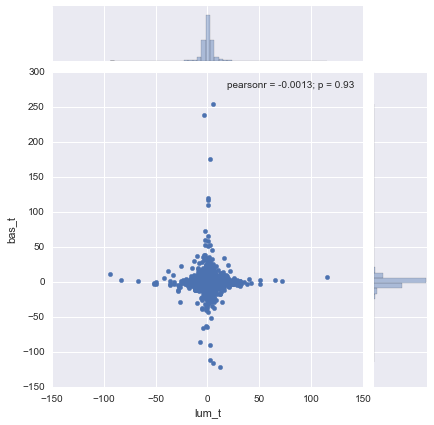

In [18]:
lum_avg.columns=['lum_t', 'lum_p']
bas_avg.columns=['bas_t', 'bas_p']
lvb_merge = lum_avg.merge(bas_avg, how='inner', left_index=True, right_index=True)
lvb_merge.to_clipboard()

%matplotlib inline
sns.jointplot(x='lum_t', y='bas_t', data=lvb_merge)

In [47]:
# null_df = randomPairContextStat(exp_samp=lum_avg.index.sample(1000), cnv_samp, expdf=exp_breast, cnvdf=cdel, nan_style='omit', permute=False):

,exp,cnv,t_stat,p_val,null
1355357,CELF3,GCOM1,1.311070,0.197913,1
654858,TM9SF3,NDUFB11,0.521705,0.605071,1
877043,ADAM2,CHCHD7,-0.719687,0.476496,1
283762,STK11IP,MOXD1,0.219580,0.826982,1
1490184,NCAN,UGT2B17,1.580024,0.119734,1
1499842,TMEM63A,LINC00617,1.602872,0.114491,1
1505047,SPIB,ALLC,-1.616328,0.111545,1
291532,SLC39A9,OR4C6,0.225414,0.822463,1
1026260,ABCB5,PPAPDC2,-0.871584,0.387092,1
1641423,FBXW9,GOPC,2.196325,0.034242,1


In [39]:
bas_avg.shape

(9542, 2)

In [40]:
lum_avg.shape

(8947, 2)

In [36]:
null_df.s

NameError: name 'null_df' is not defined

(-25, 25)

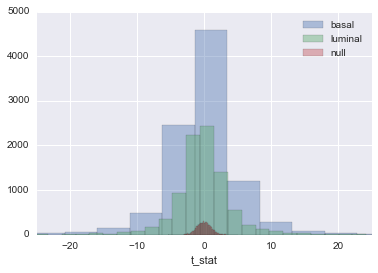

In [44]:
%matplotlib inline
null_df = pd.read_pickle('breast_ttest_null_samp.p').dropna()

sns.distplot(bas_avg['t_stat'], kde=False, bins = 100, label='basal')
sns.distplot(lum_avg['t_stat'], kde=False, bins = 100, label='luminal')
sns.distplot(null_df['t_stat'], kde=False, bins = 100, label='null')

plt.legend()
plt.xlim(-25, 25)

Luminal Target Search
https://breast-cancer-research.biomedcentral.com/articles/10.1186/bcr2904#Sec4

In [36]:
lum_avg[lum_avg.index.to_series().str.contains('CCND1')]

,t_stat,p_val
exp,,
CCND1,5.994861,0.000074


In [37]:
lum_avg[lum_avg.index.to_series().str.contains('MKI67')]

,t_stat,p_val
exp,,
MKI67,2.188824,0.064453
MKI67IP,-3.123526,0.008394


In [38]:
lum_avg[lum_avg.index.to_series().str.contains('FGF1')]

,t_stat,p_val
exp,,
FGF12,-5.557198,0.000759
FGF13,2.181216,0.082371
FGF18,-4.164815,0.003295


In [30]:
lum_avg[lum_avg.index.to_series().str.contains('AKT1')]

,t_stat,p_val
exp,,
AKT1,3.755870,0.006354
AKT1S1,0.185381,0.651618


In [31]:
lum_avg[lum_avg.index.to_series().str.contains('ZNF7')]

,t_stat,p_val
exp,,
ZNF7,4.130046,0.001177
ZNF700,-2.435787,0.029107
ZNF701,-1.812719,0.103681
ZNF704,5.415356,0.001093
ZNF706,-1.461592,0.166575
ZNF707,1.901467,0.116955
ZNF708,3.484642,0.019145
ZNF709,1.508095,0.174057
ZNF71,-3.534732,0.009623


In [19]:
lum_avg[lum_avg.index.to_series().str.contains('NHER')]

,t_stat,p_val
exp,,


In [47]:
lum_avg[lum_avg.index.to_series().str.contains('PARP')]

,t_stat,p_val
exp,,
PARP1,1.393313,0.206072
PARP10,-8.437704,0.000001
PARP11,-8.229759,0.000001
PARP12,-4.793654,0.000305
PARP14,-2.069038,0.059633
PARP16,1.406565,0.197507
PARP2,3.102926,0.020830
PARP3,-1.963498,0.094139
PARP6,-1.082947,0.326793


In [43]:
lum_avg.sort_values(by='t_stat', ascending=False)['t_stat'].head(2940).to_clipboard()

Basal Target Search
https://breast-cancer-research.biomedcentral.com/articles/10.1186/bcr2904#Sec4

In [44]:
bas_avg.sort_values(by='t_stat', ascending=False)['t_stat'].head(2940).to_clipboard()

In [45]:
bas_avg[bas_avg.index.to_series().str.contains('PARP')]

,t_stat,p_val
exp,,


In [48]:
bas_avg[bas_avg.index.to_series().str.contains('CXC')]

,t_stat,p_val
exp,,
CXCL1,-0.881478,3.061532e-01
CXCL10,-0.177683,8.612990e-01
CXCL11,1.972432,1.566779e-01
CXCL12,-4.952025,3.206873e-03
CXCL16,-6.370329,2.093993e-04
CXCL17,-1.972432,1.566779e-01
CXCL2,-17.907710,1.327710e-11
CXCL5,4.853489,3.572937e-03
CXCL6,-6.497604,5.470014e-05


In [53]:
bas_avg[bas_avg.index.to_series().str.contains('TOR')]

,t_stat,p_val
exp,,
DEPTOR,4.22013,0.005759


In [57]:
bas_avg[bas_avg.index.to_series().str.contains('CKIT')]

,t_stat,p_val
exp,,


In [58]:
bas_avg[bas_avg.index.to_series().str.contains('MAP')]

,t_stat,p_val
exp,,
DMAP1,-1.633470,1.987962e-01
ERMAP,3.948212,8.278059e-03
GIMAP2,-11.648095,3.966620e-09


# Validate with DEMETER essentiality scores

Load Achilles DEMETER essential set for comparison of basal vs luminal

In [3]:
# load DEMETER
demdf = pd.read_csv('data/Achilles_ExpandedGeneZSolsCleaned.csv')
demdf.rename(columns={'Unnamed: 0':'gene'}, inplace=True)
demdf.set_index('gene', inplace=True)

In [4]:
demdf.head()

,22RV1_PROSTATE,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,786O_KIDNEY,A1207_CENTRAL_NERVOUS_SYSTEM,A172_CENTRAL_NERVOUS_SYSTEM,A204_SOFT_TISSUE,A2058_SKIN,A549_LUNG,A673_BONE,ACHN_KIDNEY,...,UACC812_BREAST,WM115_SKIN,WM1799_SKIN,WM2664_SKIN,WM793_SKIN,WM88_SKIN,WM983B_SKIN,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,ZR751_BREAST
gene,,,,,,,,,,,,,,,,,,,,,
RPS6KA1,-0.140229,-1.899512,0.152417,-1.467356,-0.018449,-1.409920,-0.799515,-0.131832,-0.339710,0.075294,...,1.052696,0.345124,-0.536498,0.308405,-0.238742,-1.156410,-0.585219,0.774626,1.676569,0.867316
IGF1R,-0.166452,0.532207,2.091692,1.419493,1.444448,1.024176,0.041664,-0.339156,-0.748813,2.229142,...,2.041782,1.914631,1.232133,1.817584,1.354531,0.000897,-1.066889,0.553597,1.075670,0.838400
TSC1,1.514956,0.421296,0.735808,0.833647,0.399510,1.079235,0.494180,0.480317,1.118846,1.659536,...,-1.657489,-0.422418,1.354927,0.256831,5.657078,1.552982,-0.570167,1.006351,0.487447,0.612617
CHEK1,0.931882,1.113300,-2.459216,0.266536,0.871673,0.794036,-0.342840,-1.576682,1.162022,0.412978,...,2.386794,0.840381,-1.379816,0.146515,-1.886837,-0.461237,-1.158390,-0.052412,0.309435,0.764327
XRCC5,-0.286433,-0.204518,0.774626,0.851472,0.509629,0.537753,0.562707,1.140632,0.521116,1.016253,...,-1.333075,-0.016358,0.680352,-0.854178,-1.478447,1.067352,0.262694,0.003544,-0.681474,-0.324183


In [83]:
# partition df into basal and luminal
dem_lum = [col for col in demdf.columns if col[:-7] in lum]
demdf_lum = demdf[dem_lum]
demdf_lum['lum_avg'] = demdf_lum.mean(axis=1)

dem_bas = [col for col in demdf.columns if col[:-7] in bas]
demdf_bas = demdf[dem_bas]
demdf_bas['bas_avg'] = demdf_bas.mean(axis=1)

In [93]:
dem_cloves = lum_avg.join(demdf_lum['lum_avg'])
dem_cloves = dem_cloves.join(demdf_bas['bas_avg'])
dem_cloves.dropna(inplace=True)


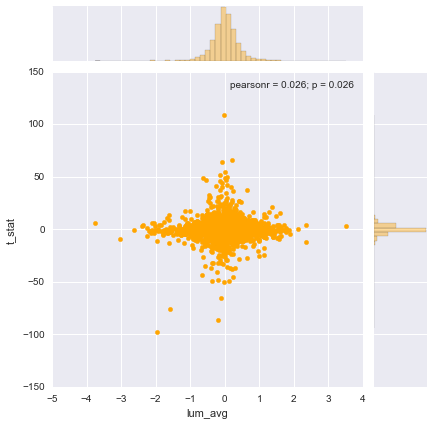

In [81]:
%matplotlib inline
sns.jointplot(x="lum_avg", y="t_stat", data=dem_cloves, color='orange')

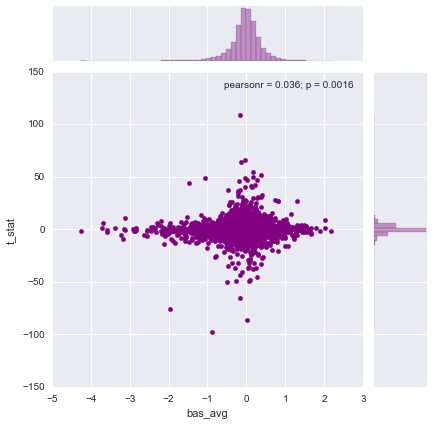

In [95]:
%matplotlib inline
sns.jointplot(x="bas_avg", y="t_stat", data=dem_cloves, color='purple')

In [233]:
# basal vs luminal differential (at level of gene module??)

DEMETER comparison of Lung Cancer subtypes

In [5]:
celldf = pd.read_pickle('cccle_cell_info_df.pickle')
ccle_lung = celldf[celldf['Site Primary'].str.contains('lung')]
ccle_lung['Hist Subtype1'].value_counts()

small_cell_carcinoma                 53
adenocarcinoma                       52
squamous_cell_carcinoma              28
non_small_cell_carcinoma             24
large_cell_carcinoma                 14
bronchioloalveolar_adenocarcinoma     5
mixed_adenosquamous_carcinoma         4
NS                                    3
undifferentiated_carcinoma            1
immortalized_epithelial               1
immortalized_embryonic_fibroblast     1
mucoepidermoid_carcinoma              1
Name: Hist Subtype1, dtype: int64

In [16]:
sclc = celldf.loc[(celldf['Hist Subtype1'] == 'small_cell_carcinoma') & (celldf['Site Primary'] == 'lung')].index
adno = celldf.loc[(celldf['Hist Subtype1'] == 'adenocarcinoma') & (celldf['Site Primary'] == 'lung')].index

## Validate with avana essentiality scores (CRISPr)

In [1]:
import pandas as pd

In [10]:
avana = pd.read_csv('avana_gene_dependency.csv', index_col=0)


In [11]:
# trim  (num) from gene names
avana.columns = [x.split(' ')[0] for x in avana.columns]

In [13]:
avana = avana.T
avana.columns = [x.split('_')[0] for x in avana.columns]

In [14]:
avana.head()

,143B,253J,42MGBA,5637,59M,639V,647V,769P,786O,8305C,...,VMCUB1,WM115,WM1799,WM2664,WM793,WM983B,YAPC,YD38,YKG1,ZR751
A1BG,0.009453,0.002104,0.004995,0.002276,0.121887,0.021005,0.018664,0.024255,0.051085,0.003262,...,0.007065,0.000899,0.007016,0.007521,0.011204,0.003298,0.014095,0.012610,0.002938,0.015881
A1CF,0.003377,0.001915,0.010838,0.031186,0.004672,0.010204,0.008075,0.000258,0.008226,0.004042,...,0.004328,0.000274,0.001545,0.009179,0.004398,0.001601,0.004692,0.011844,0.015449,0.002021
A2M,0.017404,0.004299,0.015921,0.007782,0.007513,0.030107,0.036743,0.040939,0.055443,0.073687,...,0.001741,0.140145,0.226200,0.037243,0.008189,0.019683,0.015280,0.025842,0.008791,0.005376
A2ML1,0.014460,0.000092,0.000494,0.001407,0.000526,0.024205,0.006091,0.002103,0.001379,0.007627,...,0.000762,0.000115,0.001675,0.001305,0.000867,0.002085,0.005512,0.012852,0.001751,0.000893
A3GALT2,0.010577,0.009934,0.055186,0.006403,0.017643,0.091339,0.021282,0.079645,0.022495,0.033172,...,0.012355,0.064092,0.078797,0.024897,0.009955,0.060825,0.024198,0.008657,0.152339,0.008015


## Compare observed cloves vs permuted (null) clove 

In [11]:
null = pd.read_pickle('data/breast_ttest_null_samp.p').dropna(axis=0, how='any')
null.head(5)

,exp,cnv,t_stat,p_val,null
1355357,CELF3,GCOM1,1.311070,0.197913,1
654858,TM9SF3,NDUFB11,0.521705,0.605071,1
877043,ADAM2,CHCHD7,-0.719687,0.476496,1
283762,STK11IP,MOXD1,0.219580,0.826982,1
1490184,NCAN,UGT2B17,1.580024,0.119734,1


(4282267, 3)
(3903330, 3)
(3903330, 3)


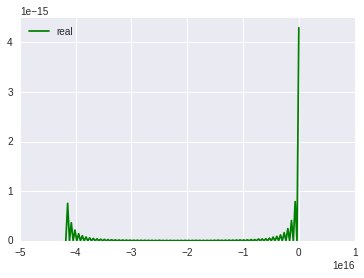

In [33]:
real = pd.read_pickle('data/breast.pickle').unstack().reset_index(name='t_stat').dropna()
print(real.shape)
real.replace([np.inf, -np.inf], np.nan, inplace=True)
real = real.dropna()
print(real.shape)
real['t_stat'] = pd.to_numeric(real['t_stat'], errors='coerce')
real = real.dropna()
print(real.shape)
sns.kdeplot(real[real['t_stat'] < 10]['t_stat'], color='green',label='real')

### make some new cloves in breast ccle

In [57]:
from cloveFunctions import *

exp_breast = pd.read_pickle('data/breast_mrna_df.pickle')
cdel = pd.read_pickle('data/CCLE_DEL_calls.pickle')
cell = pd.read_pickle('data/ccle_cell_info_df.pickle')


# this filtering step requires subsetting cdel to tissue of interest (breast)
cells = list(set(cdel.columns).intersection(exp_breast.columns)) # eliminating all contexts less than 2
cdel_breast = cdel[cells]

# exp_samp = exp_breast.sample(n=10000).index.values
# cnv_samp = cdel_breast[cdel_breast.sum(axis=1) > 1].sample(n=10000).index.values

df = randomPairContextStat(100000, exp_breast, cdel_breast, nan_style='propagate')

In [58]:
df.shape

(17140, 13)

In [100]:
df1.to_csv('data/breast_ttest_real_samp.tab.gz', sep='\t', compression='gzip')

In [59]:
df1 = randomPairContextStat(1000000, exp_breast, cdel_breast, nan_style='propagate')

In [60]:
df1.shape

(171003, 13)

In [68]:
df1.sort_values(by='np_t_w', ascending=False)

,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,t_shrnk_glob,gene_var_exp
81023,SND1,MTPAP,2,57,11.886395,9.868994,0.311526,0.137629,5.234104,7.475600,1.104898e-09,2.534720,0.281582
103625,RBM33,TGM1,2,57,7.095353,5.809255,0.656937,0.075592,4.094883,5.892039,4.568539e-07,1.433353,0.152045
95123,GRB2,NR1D1,7,52,10.816281,9.593055,0.649102,0.235567,2.253603,5.797602,6.494544e-07,2.465692,0.448698
74980,NUFIP2,ACBD4,6,53,10.611000,9.119190,0.463521,0.365146,2.393989,5.757887,7.526910e-07,2.956951,0.588430
131162,MGC27345,POP5,3,56,8.962275,7.277213,0.146375,0.265408,3.252219,5.687929,9.754418e-07,2.747854,0.403226
115992,RAB3GAP2,PGD,9,50,9.821891,8.938214,0.266703,0.179665,1.977383,5.660986,1.077616e-06,2.254497,0.298957
164034,MRPS28,LOC284080,2,57,12.892435,10.333195,0.080841,0.431651,3.882598,5.596955,1.364777e-06,3.537877,0.645193
4715,BPNT1,SNORD91B,11,48,9.208410,7.921704,0.331527,0.529909,1.801363,5.588802,1.406377e-06,3.393149,0.756875
64091,SHOC2,STK35,4,55,11.756990,9.584837,1.302189,0.556493,2.740251,5.491461,2.010865e-06,2.847390,0.920851
4708,BPNT1,FGF11,12,47,9.140291,7.911719,0.354941,0.536399,1.708629,5.482764,2.075957e-06,3.318521,0.756875


Ttest_indResult(statistic=23.582223871247624, pvalue=9.0569085308294708e-123)


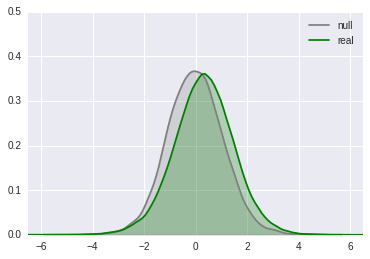

In [86]:
%matplotlib inline
sns.kdeplot(null['t_stat'], color='gray', shade=True, label='null')
sns.kdeplot(df1['np_t_w'], color='green', shade=True, label='real')
plt.xlim(-6.5, 6.5)
plt.ylim(0.00, 0.50)
print(stats.ttest_ind(df1['np_t_w'],null['t_stat']))

### Which top hits in ccle appear in synlethdb?

In [74]:
syndb = pd.read_pickle('data/synlethdb_sl_human.pickle')
syndb.set_index('GeneBSymbol', inplace=True)
syn_ccle = pd.DataFrame(df1.groupby(['exp'], sort=False)['np_t_w'].max()).merge(syndb, left_index=True, right_index=True)

In [104]:
syn_ccle = syn_ccle[~syn_ccle.index.duplicated(keep='first')]
results = syn_ccle[(syn_ccle['np_t_w'] > 3) & (syn_ccle['DiseaseScore'] > 0.20)].sort_values(by='np_t_w', ascending=False)[['GeneASymbol', 'np_t_w', 'DiseaseScore']]
results.head(50)

,GeneASymbol,np_t_w,DiseaseScore
SND1,MYC,7.475600,0.551
MTR,KRAS,5.129919,0.452
RAD51C,NAE1,5.054065,0.575
NVL,NRAS,4.981331,0.470
SMC1A,PARP2,4.826752,0.855
ZFYVE16,NAE1,4.777201,0.629
CDK12,BRCA1,4.735929,0.560
SCYL3,NAE1,4.731202,0.500
PPFIA1,NRAS,4.730720,0.461
ZNF507,NAE1,4.611814,0.575


In [83]:
syn_ccle2 = syn_ccle[(syn_ccle['np_t_w'] > 4) & (syn_ccle['Evidence'] == 'Daisy')].sort_values(by='DiseaseScore', ascending=False)

,np_t_w,GeneASymbol,GeneAid,GeneBid,PubmedID,Evidence,Type,Species,DiseaseScore
RAB11FIP1,5.404053,MAL2,114569,80223,25171417,Daisy,SDL,NaN,0.200
TMEM134,4.347080,RAB1B,81876,80194,25171417,Daisy,SDL,NaN,0.200
RAD51C,5.054065,NME1,4830,5889,25171417,Daisy,SDL,NaN,0.200
RAD51C,5.054065,CCT2,10576,5889,25171417,Daisy,SDL,NaN,0.200
RAD51C,5.054065,C17orf80,55028,5889,25171417,Daisy,SDL,NaN,0.200
RANBP2,4.069245,CPNE1,8904,5903,25171417,Daisy,SDL,NaN,0.200
RBM33,5.892039,EZH2,2146,155435,25171417,Daisy,SDL,NaN,0.200
RCHY1,4.556471,G3BP2,9908,25898,25171417,Daisy,SDL,NaN,0.200
RCOR3,4.477705,ARID4B,51742,55758,25171417,Daisy,SDL,NaN,0.200
RCOR3,4.477705,ILF2,3608,55758,25171417,Daisy,SDL,NaN,0.200


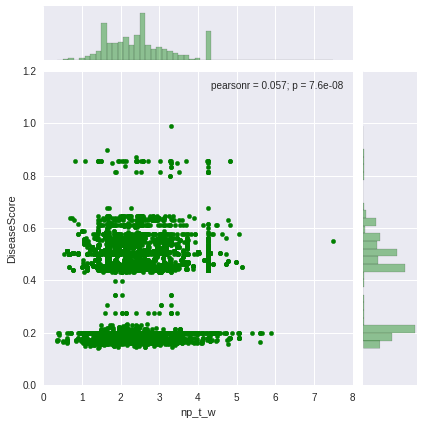

In [84]:
sns.jointplot(x='np_t_w', y='DiseaseScore', data=syn_ccle, color='green')

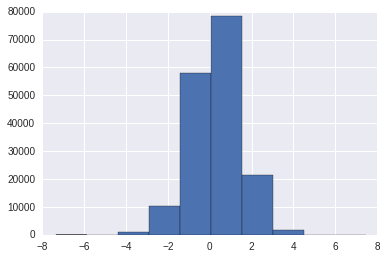

In [92]:
d = pd.DataFrame(df1.groupby(['exp'], sort=False)['np_t_w'].max())
df1['np_t_w'].hist()

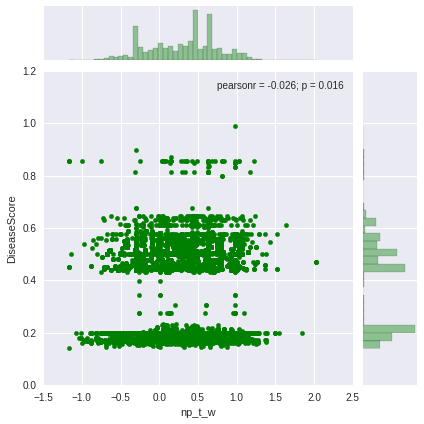

In [93]:
syn_ccle_1 = pd.DataFrame(df1.groupby(['exp'], sort=False)['np_t_w'].mean()).merge(syndb, left_index=True, right_index=True)
sns.jointplot(x='np_t_w', y='DiseaseScore', data=syn_ccle_1, color='green')

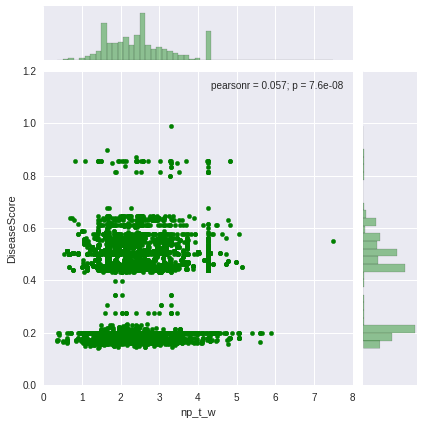

In [106]:
syn_ccle = pd.DataFrame(df1.groupby(['exp'], sort=False)['np_t_w'].max()).merge(syndb, left_index=True, right_index=True)
sns.jointplot(x='np_t_w', y='DiseaseScore', data=syn_ccle, color='green')

### Compare with Avana

In [107]:
avana = pd.read_csv('data/avana_gene_dependency.tab.gz', compression='gzip', sep='\t', index_col=0)
avana.columns = [x.split(' ')[0] for x in avana.columns]
avana = avana.T
avana.columns = [x.split('_')[0] for x in avana.columns]
avana = avana.T

avana_dim = avana.shape

In [112]:
avana.head(2)

,143B,253J,42MGBA,5637,59M,639V,647V,769P,786O,8305C,...,VMCUB1,WM115,WM1799,WM2664,WM793,WM983B,YAPC,YD38,YKG1,ZR751
A1BG,0.009453,0.002104,0.004995,0.002276,0.121887,0.021005,0.018664,0.024255,0.051085,0.003262,...,0.007065,0.000899,0.007016,0.007521,0.011204,0.003298,0.014095,0.012610,0.002938,0.015881
A1CF,0.003377,0.001915,0.010838,0.031186,0.004672,0.010204,0.008075,0.000258,0.008226,0.004042,...,0.004328,0.000274,0.001545,0.009179,0.004398,0.001601,0.004692,0.011844,0.015449,0.002021


In [108]:
df1.set_index('exp', inplace=True)

In [111]:
df1_1 = df1[~df1.index.duplicated(keep='first')]

In [113]:
df1_1.head(2)

,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,t_shrnk_glob,gene_var_exp
exp,,,,,,,,,,,,
VPS13A,PLXDC1,4,55,6.976154,7.271535,0.336653,0.574109,-0.388663,-0.550514,0.456032,-0.505914,0.573240
AURKA,C11orf34,9,50,10.552222,10.781497,0.540158,0.883054,-0.247248,-0.482831,0.497479,-0.515146,0.851983


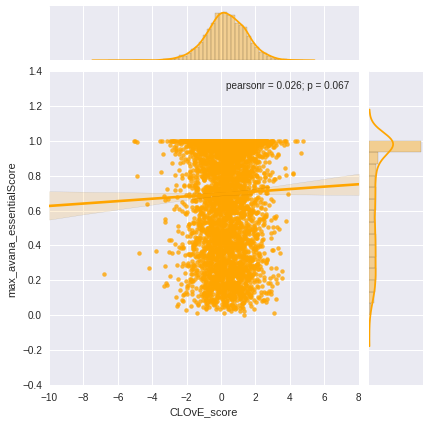

In [114]:
max_merge = df1_1[['np_t_w']].merge(pd.DataFrame(avana.max(axis=1)), left_index=True, right_index=True)

max_merge.columns = ['CLOvE_score', 'max_avana_essentialScore']
# max_merge = max_merge[max_merge['sum clDEG connection'] > 3000]
sns.jointplot(y='max_avana_essentialScore', x='CLOvE_score', data=max_merge, color='orange', kind='reg')

In [115]:
## Validate with DEMETER
demeter = pd.read_csv('data/Achilles_ExpandedGeneZSolsCleaned.csv')
demeter.rename(columns={'Unnamed: 0':'gene'}, inplace=True)
demeter.set_index('gene', inplace=True)
demeter_brca = demeter[[col for col in demeter.columns if 'BREAST' in col]]
demeter_brca['demeter_avg'] = demeter_brca.mean(axis=1)

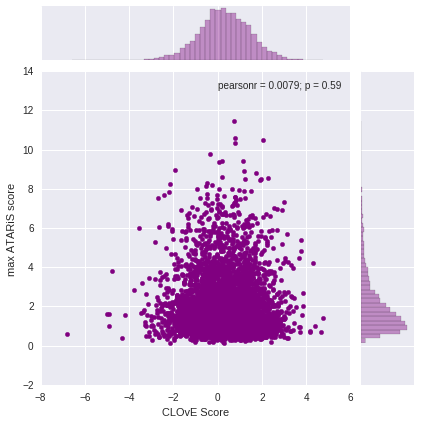

In [116]:
max_merge = df1_1[['np_t_w']].merge(pd.DataFrame(demeter_brca.max(axis=1)), left_index=True, right_index=True)
max_merge.columns = ['CLOvE Score', 'max ATARiS score']
%matplotlib inline
sns.jointplot(x="CLOvE Score", y="max ATARiS score", data=max_merge, color='purple')

In [117]:
max_merge.sort_values(by='max ATARiS score', ascending=False)

,CLOvE Score,max ATARiS score
TUBGCP2,0.755721,11.475933
MED14,0.777886,10.592608
EEF1A1,2.035480,10.509425
SMC1A,0.778782,10.311370
VCP,-0.332057,9.756816
CSE1L,1.152467,9.424084
AMMECR1,0.176217,9.412200
IPO7,0.056641,9.364667
NPTN,-1.924249,8.936868
VPS28,1.191359,8.889335


In [119]:
max_merge[(max_merge['CLOvE Score'] > 2) & (max_merge['max ATARiS score'] > 7)]

,CLOvE Score,max ATARiS score
NUP133,2.987980,7.344506
EEF1A1,2.035480,10.509425
GAPDH,2.541859,7.031579
POP4,2.266832,8.528875


### Compare CLOvEs computed in expression vs essentiality

In [32]:
from cloveFunctions import *
import pandas as pd

ccle = pd.read_csv('data/breast_ttest_real_samp.tab.gz', sep='\t', compression='gzip')

achilles gene dependency clove versus ccle cloves

In [5]:
# # downsampling to breast
# dep_breast = pd.read_csv('data/Achilles_gene_dependency.csv', index_col=0).T
# dep_breast = dep_breast[[col for col in dep_breast.columns if 'BREAST' in col]]
# dep_breast.columns = [col.split('_')[0] for col in dep_breast.columns]
# dep_breast.index = [x.split(' ')[0] for x in dep_breast.index]

# cdel = pd.read_pickle('data/CCLE_DEL_calls.pickle')
# cdel_breast = cdel[[col for col in cdel.columns if 'BREAST' in col]]
# cdel_breast.columns = [col.split('_')[0] for col in cdel_breast.columns]

# breast_lines = get_breast_lines(mode='r')

In [6]:
def get_breast_lines(fil='data/breast_ccle_lines.txt', mode='r'):
    if mode == 'w':
        breast_cells = [x[:-8] for x in breast.columns]
        with open(fil, mode) as fh:
            for b in breast_cells:
                fh.write(b+'\n')
    elif mode == 'r':
        with open(fil, mode) as fh:
            return([x.strip() for x in fh.readlines()])

In [8]:
cdel_breast = pd.read_csv('data/breast_CCLE_DEL_calls.csv.gz', compression='gzip', index_col=0)
dep_breast = pd.read_csv('data/breast_Achilles_gene_dependency.csv.gz', compression='gzip', index_col=0)

In [28]:
# this filtering step requires subsetting cdel to tissue of interest (breast)
cells = list(set(cdel_breast.columns).intersection(dep_breast))

In [29]:
# exp_samp = exp_breast.sample(n=10000).index.values
# cnv_samp = cdel_breast[cdel_breast.sum(axis=1) > 1].sample(n=10000).index.values

deme = randomPairContextStat(100000, dep_breast[cells], cdel_breast[cells], nan_style='propagate')

In [42]:
merged = pd.merge(deme[['exp', 'cnv', 'np_t_w']], ccle[['exp', 'cnv', 'np_t_w']],  how='left', left_on=['exp', 'cnv'], right_on = ['exp', 'cnv'])
merged.columns = ['exp', 'cnv', 'clove_dep', 'clove_ccle']


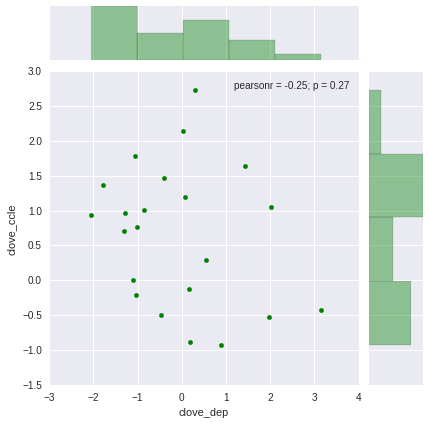

In [46]:
%matplotlib inline
sns.jointplot(x="clove_dep", y="clove_ccle", data=merged, color='green')

In [43]:
merged

,exp,cnv,clove_dep,clove_ccle
0,NDUFS1,RCBTB2,-0.758386,NaN
1,NDUFS1,ODZ1,0.152280,NaN
2,NDUFS1,RASL10B,0.079047,NaN
3,BSX,ELANE,2.047540,NaN
4,CADM1,RAET1E,-0.441029,NaN
5,CADM1,MIRLET7A3,-0.403220,NaN
6,CADM1,KCNRG,0.923141,NaN
7,CADM1,CCDC64,-0.481536,NaN
8,CADM1,GCAT,-0.403220,NaN
9,SERINC4,SDHAF2,0.214861,NaN


### achilles z scores vs ccle

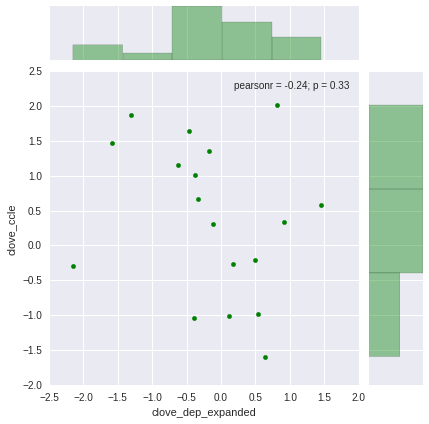

In [47]:
cdel_breast = pd.read_csv('data/breast_CCLE_DEL_calls.csv.gz', compression='gzip', index_col=0)
dep_breast = pd.read_csv('data/breast_Achilles_ExpandedGeneZSolsCleaned.csv.gz', compression='gzip', index_col=0)

cells = list(set(cdel_breast.columns).intersection(dep_breast))

deme = randomPairContextStat(100000, dep_breast[cells], cdel_breast[cells], nan_style='propagate')

merged = pd.merge(deme[['exp', 'cnv', 'np_t_w']], ccle[['exp', 'cnv', 'np_t_w']],  how='left', left_on=['exp', 'cnv'], right_on = ['exp', 'cnv'])
merged.columns = ['exp', 'cnv', 'clove_dep_expanded', 'clove_ccle']

sns.jointplot(x="clove_dep_expanded", y="clove_ccle", data=merged, color='green')

### achilles scores compared to clDEG

In [3]:
from scipy.stats.stats import pearsonr 
import itertools

cldeg from ccle

In [21]:
exp = pd.read_pickle('data/breast_mrna_df.pickle')
cnv = pd.read_csv('data/breast_CCLE_DEL_calls.csv.gz', index_col=0, compression='gzip')
hits = pd.read_csv('data/breast_ttest_real_samp.tab.gz', sep='\t', index_col=0, compression='gzip')

cldeg = vulnerability_vector_count(exp, cnv, hits)
dep_breast = pd.read_csv('data/breast_Achilles_gene_dependency.csv.gz', compression='gzip', index_col=0)

In [22]:
def correlate_df_cols(df_1, df_2, comb=False, perm=False):
    """
    finds pearson coefficient between columns of two pandas dataframes
    
    :param df_1: pandas dataframe
    :param df_2: pandas dataframe
    :param comb: bool, changes how/which column comparisons are made:
                    True: correlation between all combinations of cols
                    False: correlation between matching column headers (default)
    :param perm: bool, permute the cell order in df1 so as to destroy cell-to-cell comparision
                    True: permutes column headers with df1, null dist
                    False: keeps df1 column headers in natural order, preserves cell-to-cell comparisons (default)
    
    returns pandas dataframe of correlations
    """
    
    idx_1, idx_2 = df_1.index, df_2.index
    labels = idx_1.intersection(idx_2)
    df_1, df_2 = df_1.loc[labels], df_2.loc[labels]
    cldeg, dep_breast = df_1, df_2
    
    if perm:
        df_1_cols = np.array(df_1.columns)
        np.random.shuffle(df_1_cols)
        df_1.columns=df_1_cols
    
    if comb:
        cldeg_depBreast_corr = [['sample','cell','pear_coeff','p_val']]
        completed = []
        for pair in itertools.product(cldeg.columns, dep_breast.columns):
            if (pair[0] != pair[1]) & (pair[::-1] not in completed):
                corr = pearsonr(cldeg[pair[0]], dep_breast[pair[1]])
                cldeg_depBreast_corr.append([pair[0], pair[1], corr[0], corr[1]])
                completed.append(pair)
    else:
        cldeg_depBreast_corr = [['cell','pear_coeff','p_val']]
        for cell in cldeg.columns:
            if cell in dep_breast.columns:
                corr = pearsonr(cldeg[cell], dep_breast[cell])
                cldeg_depBreast_corr.append([cell, corr[0], corr[1]])

    cols = cldeg_depBreast_corr.pop(0)
    df_corr = pd.DataFrame(cldeg_depBreast_corr)
    df_corr.columns = cols
    return df_corr
        

In [77]:
corr = correlate_df_cols(cldeg, dep_breast)
corr_null = correlate_df_cols(cldeg, dep_breast,perm=True)

In [78]:
red_corr=corr_null[corr_null['pear_coeff']<0.30]

Ks_2sampResult(statistic=0.36813186813186816, pvalue=0.064362913467115174)


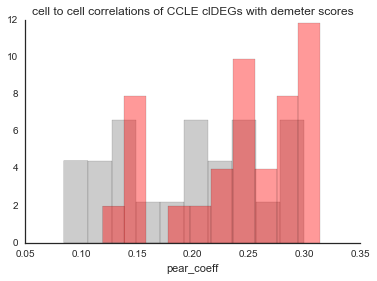

In [79]:
%matplotlib inline
sns.set_style("white")
sns.distplot(red_corr['pear_coeff'], color='gray',kde=False, norm_hist=True,bins=10)

sns.distplot(corr['pear_coeff'], color='red',kde=False,norm_hist=True,bins=10)
plt.title('cell to cell correlations of CCLE clDEGs with demeter scores')
sns.despine()

print(stats.ks_2samp(red_corr['pear_coeff'], corr['pear_coeff']))


Ks_2sampResult(statistic=0.36813186813186816, pvalue=0.064362913467115174)


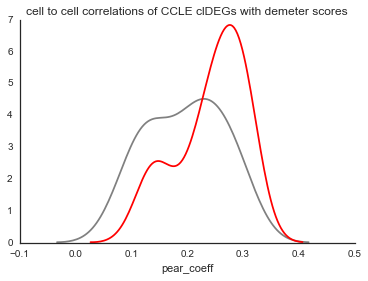

In [81]:
%matplotlib inline
sns.set_style("white")
sns.distplot(red_corr['pear_coeff'], color='gray',hist=False, kde=True)

sns.distplot(corr['pear_coeff'], color='red',hist=False, kde=True)
plt.title('cell to cell correlations of CCLE clDEGs with demeter scores')
sns.despine()

print(stats.ks_2samp(red_corr['pear_coeff'], corr['pear_coeff']))

Ks_2sampResult(statistic=0.36813186813186816, pvalue=0.064362913467115174)


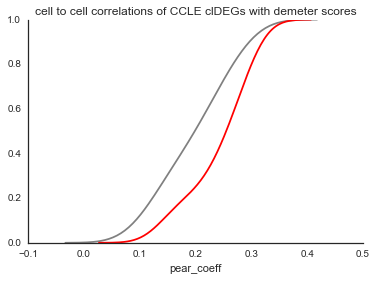

In [82]:
%matplotlib inline
sns.set_style("white")
sns.distplot(red_corr['pear_coeff'], color='gray',hist=False, kde=True, kde_kws=dict(cumulative=True))

sns.distplot(corr['pear_coeff'], color='red',hist=False, kde=True, kde_kws=dict(cumulative=True))
plt.title('cell to cell correlations of CCLE clDEGs with demeter scores')
sns.despine()

print(stats.ks_2samp(red_corr['pear_coeff'], corr['pear_coeff']))

In [ ]:
red_corr['null'] = 1
corr['null'] = 0

pd.concat([red_corr, corr]).to_csv('data/breast_realVnull_clDEG_demeter.tab', sep='\t')

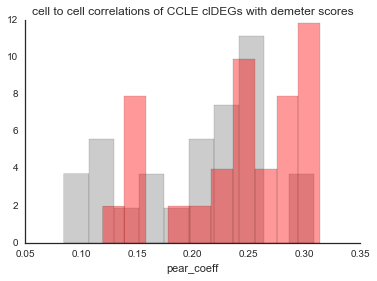

In [11]:
%matplotlib inline
sns.set_style("white")
sns.distplot(red_corr['pear_coeff'], color='gray',kde=False, norm_hist=True,bins=10)

sns.distplot(corr['pear_coeff'], color='red',kde=False,norm_hist=True,bins=10)
plt.title('cell to cell correlations of CCLE clDEGs with demeter scores')
sns.despine()


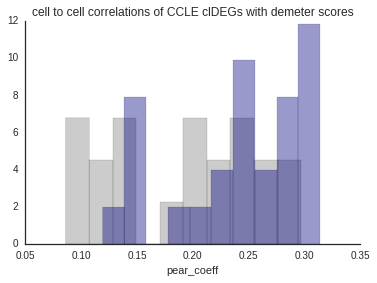

In [166]:
%matplotlib inline
sns.set_style("white")
sns.distplot(red_corr['pear_coeff'], color='gray',kde=False, norm_hist=True,bins=10)

sns.distplot(corr['pear_coeff'], color='navy',kde=False,norm_hist=True,bins=10)
plt.title('cell to cell correlations of CCLE clDEGs with demeter scores')
sns.despine()


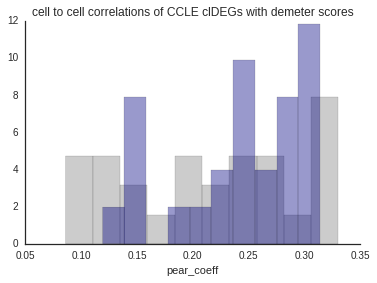

In [63]:
%matplotlib inline
sns.set_style("white")
sns.distplot(corr_null['pear_coeff'], color='gray',kde=False, norm_hist=True,bins=10)

sns.distplot(corr['pear_coeff'], color='navy',kde=False,norm_hist=True,bins=10)
plt.title('cell to cell correlations of CCLE clDEGs with demeter scores')
sns.despine()


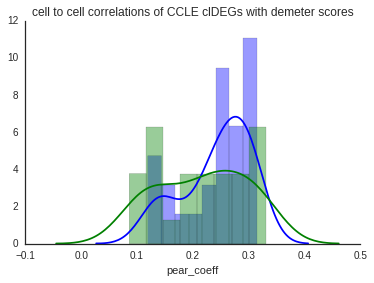

In [57]:
%matplotlib inline
sns.set_style("white")
sns.distplot(corr['pear_coeff'], color='b',kde=True, bins=8)
sns.distplot(corr_null['pear_coeff'], color='g',kde=True, bins=8)
plt.title('cell to cell correlations of CCLE clDEGs with demeter scores')
sns.despine()

clDEG from TCGA

In [60]:
cldeg_tcga = pd.read_csv('data/brca_het_clDEG_count.tab.gz', sep='\t', index_col=0, compression='gzip')
dep_breast_tcga = pd.read_csv('data/breast_Achilles_gene_dependency.csv.gz', compression='gzip', index_col=0)

corr_tcga = correlate_df_cols(cldeg, dep_breast, comb=True,perm=False)
corr_tcga_null = correlate_df_cols(cldeg, dep_breast, comb=True,perm=False)


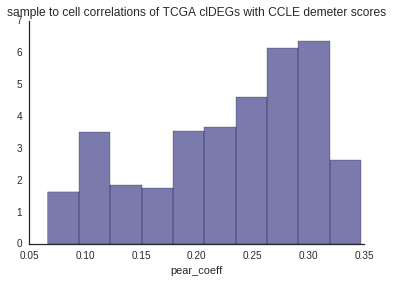

In [64]:
%matplotlib inline
sns.set_style("white")
sns.distplot(corr_tcga_null['pear_coeff'], color='gray',kde=False, norm_hist=True,bins=10)

sns.distplot(corr_tcga['pear_coeff'], color='navy',kde=False,norm_hist=True,bins=10)
plt.title('sample to cell correlations of TCGA clDEGs with CCLE demeter scores')
sns.despine()



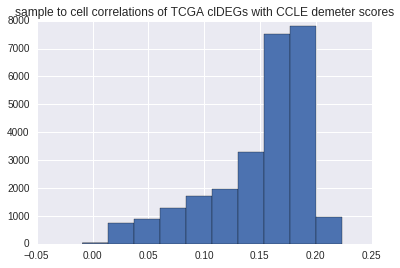

In [37]:
# corr.shape[1] - corr.dropna().shape[1]
corr.pear_coeff.hist()
plt.title('sample to cell correlations of TCGA clDEGs with CCLE demeter scores')

### Lu's Neg (SL Pair) - NoNeg (non-SL Pair) comparison

breast -- only 6 overlapping pairs

In [52]:
lu = pd.read_excel('data/lu_negNoNeg_journal.pone.0125795.s003.XLSX')
lu.columns = ['cnv', 'exp', 'class','homozygous_del','heterozygous_del','mixed_del','co_underexpression','expression_up_down']

hits = pd.read_csv('data/breast_ttest_real_samp.tab.gz', sep='\t', index_col=0, compression='gzip')

merged = pd.merge(lu[['exp', 'cnv', 'class']], hits[['exp', 'cnv', 'np_t_w']],  how='left', left_on=['exp', 'cnv'], right_on = ['exp', 'cnv'])

In [54]:
merged.dropna()

,exp,cnv,class,np_t_w
2370,TRIM24,PRDM10,noNeg,2.275534
3259,CHAF1A,MTF2,noNeg,-1.235501
3771,SETD2,SIN3A,noNeg,1.461249
4127,PHF11,MGMT,noNeg,-0.338146
4341,DMAP1,PRMT3,noNeg,0.790790
5909,ZNF263,KRAS,noNeg,0.238885


colon -- no overlapping cnv and exp values in common between lu dataset and clove columns

In [59]:
# make colon cloves
# colon lines are marked as being from "large intestine"
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4062414/

exp = pd.read_pickle('data/large_intestine_mrna_df.pickle')
cnv = pd.read_csv('data/large_intestine_CCLE_DEL_calls.csv.gz', index_col=0, compression='gzip')
colo = randomPairContextStat(100000, exp, cnv, nan_style='propagate')

In [64]:
colo_null = randomPairContextStat(100000, exp, cnv, nan_style='propagate', permute=True)

In [87]:
# colo.to_csv('large_intestine_ttest_real_samp.tab.gz', sep='\t', compression='gzip')
# colo_null.to_csv('large_intestine_ttest_null_samp.tab.gz', sep='\t', compression='gzip')

colo = pd.read_csv('data/large_intestine_ttest_real_samp.tab.gz', sep='\t', compression='gzip', index_col=0)
colo_null = pd.read_csv('data/large_intestine_ttest_null_samp.tab.gz', sep='\t', compression='gzip', index_col=0)

Ttest_indResult(statistic=-7.1465428068941117, pvalue=9.1509824604642343e-13)


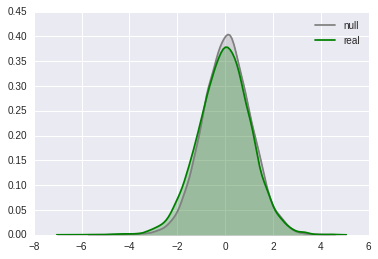

In [85]:
%matplotlib inline
sns.kdeplot(colo_null['np_t_w_null'], color='gray', shade=True, label='null')
sns.kdeplot(colo_null['np_t_w'], color='green', shade=True, label='real')
# plt.xlim(-6.5, 6.5)
# plt.ylim(0.00, 0.50)
print(stats.ttest_ind(colo_null['np_t_w'], colo_null['np_t_w_null']))

In [71]:
colo_null.shape

(12118, 15)

In [75]:
lu = pd.read_excel('data/lu_negNoNeg_journal.pone.0125795.s003.XLSX')
lu.columns = ['cnv', 'exp', 'class','homozygous_del','heterozygous_del','mixed_del','co_underexpression','expression_up_down']

merged = pd.merge(lu[['exp', 'cnv', 'class']], colo_null[['exp', 'cnv', 'type','np_t_w','np_t_w_null']],  how='left', left_on=['exp', 'cnv'], right_on = ['exp', 'cnv'])

In [79]:
lu.head()

,cnv,exp,class,homozygous_del,heterozygous_del,mixed_del,co_underexpression,expression_up_down
0,CHD1,CBX4,Neg,0.000000,0.234078,0.228814,0.007547,0.242857
1,ZMYND8,CBX4,Neg,0.000000,0.094862,0.000000,0.019608,0.227273
2,ACTL6A,HDAC5,Neg,0.028571,0.124579,0.055556,0.013667,0.537408
3,BRD4,SETD2,Neg,0.012346,0.236201,0.187500,0.232451,0.046103
4,SMYD2,SETD2,Neg,0.012346,0.121420,0.279279,0.054303,0.246332


In [80]:
colo_null.head()

,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,np_t_w_null,t_shrnk_glob,gene_var_exp,type
0,C12orf26,ICMT,3,55,8.131895,7.695633,0.246858,0.423015,0.666313,1.123845,0.265873,1.562349,0.718406,0.430664,null
1,C12orf26,CTAGE11P,2,56,7.702751,7.718750,0.001202,0.438303,-0.024164,-0.033579,0.973332,-1.773115,-0.024711,0.430664,null
2,C12orf26,C8orf48,14,44,7.625737,7.747617,0.447155,0.412043,-0.184681,-0.601863,0.549694,-2.108474,-0.357883,0.430664,null
3,INVS,CNR1,3,55,7.042054,7.570806,0.014461,0.305583,-0.963919,-1.625805,0.109606,-1.147142,-0.983277,0.309576,null
4,INVS,EXOC4,4,54,7.835554,7.521820,0.069984,0.314802,0.564799,1.089950,0.280403,1.734279,0.645412,0.309576,null


Laufner Comparison

In [3]:
lauf = pd.read_csv('data/lauf_interaction_nmeth.2436-S6_simple.csv')

In [4]:
lauf

,Target,Design,Query,Design.1,count_?,count_padj,cell_major_axis_?,cell_major_axis_padj,quant1_nuc_intsty_?,quant1_nuc_intsty_padj,...,nuc_intsty_var_?,nuc_intsty_var_padj,nuc_area_?,nuc_area_padj,tubulin_haralick_?,tubulin_haralick_padj,actin_eccentric_?,actin_eccentric_padj,tubulin_intsty_var_?,tubulin_intsty_var_padj
0,TDRD6,#1,DPF2,#1,-0.189105,0.683795,0.625975,0.028498,-0.320386,0.188783,...,-0.034302,0.926150,0.826304,0.184392,-0.134466,0.842531,0.210892,0.436721,-0.128923,0.732454
1,PRDM11,#1,DPF2,#1,-0.347725,0.416690,0.711126,0.018337,-0.294659,0.187072,...,-0.245223,0.378896,0.702785,0.149961,-0.088795,0.914442,0.319020,0.240187,-0.372926,0.290267
2,KDM1B,#1,DPF2,#1,-0.733983,0.094853,-0.157027,0.460749,-0.270442,0.238286,...,0.482291,0.070097,0.322510,0.533382,-0.577939,0.245323,-0.183565,0.547612,0.338162,0.478170
3,INTS12,#1,DPF2,#1,0.334538,0.578579,0.443023,0.111801,-0.465420,0.091092,...,-0.491885,0.066496,-0.095127,0.916832,-0.165218,0.798209,0.059385,0.851929,-0.907221,0.034397
4,ARID3C,#1,DPF2,#1,0.127576,0.793255,-0.118984,0.526675,0.063852,0.815270,...,-0.005048,0.990163,-0.034714,0.966488,-0.624882,0.211392,0.139860,0.626164,-0.208719,0.560753
5,JMJD4,#1,DPF2,#1,-0.432607,0.295264,-0.508860,0.145133,0.173506,0.459377,...,0.796081,0.014299,-0.164661,0.810278,-0.065316,0.938440,-0.901467,0.084604,1.003991,0.026053
6,SHPRH,#1,DPF2,#1,-0.417037,0.349078,-0.035084,0.898154,-0.137819,0.566883,...,0.157100,0.583518,-0.451765,0.439343,-0.406774,0.448341,-0.092899,0.762581,0.379782,0.269536
7,PHF23,#1,DPF2,#1,-0.301066,0.513005,-0.051547,0.807266,-0.388747,0.102566,...,0.343900,0.228429,0.083297,0.901932,-0.239323,0.686414,-0.070345,0.820840,0.171846,0.638094
8,TDRD5,#1,DPF2,#1,-0.439592,0.295437,-0.280960,0.220522,-0.281236,0.278086,...,0.377379,0.150905,-0.419230,0.507545,-0.271738,0.669770,-0.314827,0.245409,0.184282,0.619205
9,BRD9,#1,DPF2,#1,0.016184,0.979716,0.092236,0.630015,0.141811,0.548717,...,0.213278,0.453437,0.135100,0.830834,0.276952,0.638859,-0.164075,0.552098,0.277922,0.421498


Vizeacoumar Comparison

In [92]:
viz = pd.read_csv('data/viz_HCT116_GARP-score.txt.tar.gz', compression='gzip', sep='\t', index_col=0)
viz.sort_values(by='HCT116_PTEN', ascending=False)

,Gene Name,Gene ID,Description,HCT116_BLM,HCT116_MUS81,HCT116_PTEN,HCT116_PWT,HCT116_PTTG1,HCT116_WT,Unnamed: 10
HCT116_GARP-score.txt,,,,,,,,,,
NM_198271,LMOD3,56203,leiomodin 3 (fetal),-0.023610,-0.107275,0.179618,-0.027157,-0.152384,-0.042729,NaN
NM_004304,ALK,238,anaplastic lymphoma receptor tyrosine kinase,-0.460154,-0.236000,0.128037,-0.211280,-0.395683,-0.155110,NaN
NM_002933,RNASE1,6035,"ribonuclease, RNase A family, 1 (pancreatic)",-0.214364,-0.082907,0.119153,-0.114427,-0.166817,-0.036040,NaN
NM_000440,PDE6A,5145,"phosphodiesterase 6A, cGMP-specific, rod, alpha",-0.004440,-0.044221,0.105553,-0.050097,-0.031184,-0.100526,NaN
NM_004618,TOP3A,7156,topoisomerase (DNA) III alpha,0.062371,0.040624,0.095566,0.047371,0.027786,0.070720,NaN
NM_021139,UGT2B4,7363,"UDP glucuronosyltransferase 2 family, polypept...",-0.270479,-0.162128,0.093906,-0.116390,-0.123785,-0.074741,NaN
XM_374406,TMEM195,392636,transmembrane protein 195,0.014203,-0.029878,0.086897,-0.057707,-0.018716,-0.046635,NaN
NM_001001696,-,400997,hypothetical FLJ44006,0.073164,0.065978,0.082283,0.050784,-0.021749,0.035836,NaN
NM_203374,ZNF784,147808,zinc finger protein 784,-0.116748,0.067402,0.082011,0.032681,0.013694,0.003305,NaN


In [94]:
colo = pd.read_csv('data/large_intestine_ttest_real_samp.tab.gz', compression='gzip', index_col=0, sep='\t')
colo[colo['cnv'].str.contains('BLM')]

,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,t_shrnk_glob,gene_var_exp,type


In [96]:
colo[colo['cnv'].str.contains('MUS81')]

,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,t_shrnk_glob,gene_var_exp,type
4210,C3orf75,MUS81,2,56,8.830277,8.461085,0.726253,0.235283,0.722349,1.003789,0.319798,0.418550,0.261256,real
7524,LOC93622,MUS81,2,56,8.721165,9.062151,0.016911,0.370327,-0.559872,-0.778008,0.439839,-0.522562,0.368362,real


In [97]:
colo[colo['cnv'].str.contains('PTEN')]

,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,t_shrnk_glob,gene_var_exp,type


In [98]:
colo[colo['cnv'].str.contains('PTTG1')]

,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,t_shrnk_glob,gene_var_exp,type
4415,IRAK4,PTTG1IP,2,56,6.912958,6.610824,0.048479,0.297865,0.551990,0.767055,0.446271,0.455339,0.297433,real
6357,LUC7L3,PTTG1IP,2,56,10.937355,11.389663,0.001108,0.272206,-0.866870,-1.204617,0.233418,-0.701158,0.274400,real
7227,LOC100506661,PTTG1IP,2,56,6.075153,7.006525,0.001599,0.469426,-1.359294,-1.888897,0.064088,-1.437303,0.490634,real


### compare next k neighbors on chromosome
Let all the t-stats calculated for all genes when using gene A as the copy loss context be the “Transcriptome-Wide Response to Loss (TRL) Vector” of gene A, the context gene. Plot correlation of gene’s TRL to its k neighbors’ TRLs as you slide down the chromosome. Heatmap shows red is correlated, light is uncorrelated. Like a chromatin interaction map diagram. 

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from cloveFunctions import *
import itertools

compute more combinations of loss genes with even more exp genes

In [10]:


# # data sources for CLOvE computation
# edf = pd.read_csv('data/breast_mrna.tab.gz', compression='gzip', sep='\t', index_col=0)
# cdf = pd.read_csv('data/breast_CCLE_DEL_calls.csv.gz', compression='gzip', index_col=0)

# #filter data sources
# edf_f, cdf_f = mainFitler(edf, cdf, var=2, n=6, amp_fh=False, dele_fh=False, mut_fh=False, save=False)

# # array of bait genes on chr1
# chr1 = pd.read_csv('data/breast_ttest_real_chr1_samp.tab.gz', sep='\t', compression='gzip', index_col=0)['cnv'].unique()

# df = explicitPairContextStat(edf_f, cdf_f, cnv_lis=chr1)

SNHG12 not found in cnvdf.index.  Omitted
ATPAF1 not found in cnvdf.index.  Omitted
UQCRH not found in cnvdf.index.  Omitted
MED8 not found in cnvdf.index.  Omitted
OVGP1 not found in cnvdf.index.  Omitted
IQCC not found in cnvdf.index.  Omitted
PRPF38B not found in cnvdf.index.  Omitted
AKIRIN1 not found in cnvdf.index.  Omitted
DR1 not found in cnvdf.index.  Omitted
DMRTB1 not found in cnvdf.index.  Omitted
MUTYH not found in cnvdf.index.  Omitted
DPYD not found in cnvdf.index.  Omitted
SYNC not found in cnvdf.index.  Omitted
RAVER2 not found in cnvdf.index.  Omitted
ABCD3 not found in cnvdf.index.  Omitted
PALMD not found in cnvdf.index.  Omitted
KIAA1522 not found in cnvdf.index.  Omitted
NKAIN1 not found in cnvdf.index.  Omitted
EPB41 not found in cnvdf.index.  Omitted
ZYG11A not found in cnvdf.index.  Omitted
CD101 not found in cnvdf.index.  Omitted
TMEM54 not found in cnvdf.index.  Omitted
GPSM2 not found in cnvdf.index.  Omitted
DNAJA1P5 not found in cnvdf.index.  Omitted
PGCP1

In [3]:
df = pd.read_csv('data/breast_ttest_real_chr1_samp.tab.gz', sep='\t', compression='gzip', index_col=0)
# df.to_csv('data/breast_ttest_real_chr1_samp.tab.gz', sep='\t', compression='gzip')

df.head()

,cnv,exp,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,gene_var_exp
0,LCE3B,AP1S2,36,23,7.444176,7.556556,2.658488,2.870178,-0.066719,-0.249940,0.803532,2.791326
1,MIR4252,AP1S2,8,51,6.572774,7.631548,1.248565,2.826595,-0.643837,-1.693090,0.095898,2.791326
2,CHD5,AP1S2,11,48,6.563498,7.699847,1.043250,2.893025,-0.699698,-2.093155,0.040797,2.791326
3,CDA,AP1S2,7,52,6.484279,7.623100,1.133079,2.807001,-0.693074,-1.721489,0.090586,2.791326
4,ARHGEF10L,AP1S2,6,53,6.495331,7.600361,1.289345,2.784516,-0.669429,-1.554146,0.125685,2.791326


In [4]:
df = map_locus(df, sort=False)
df

,cnv,exp,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,gene_var_exp,chromosome
0,LCE3B,AP1S2,36,23,7.444176,7.556556,2.658488,2.870178,-0.066719,-0.249940,0.803532,2.791326,1q21.3
1,LCE3B,CD9,36,23,11.651814,11.787520,1.849409,2.255504,-0.094137,-0.352653,0.725649,2.046789,1q21.3
2,LCE3B,CEBPD,36,23,8.503124,9.320153,2.173966,1.883615,-0.559414,-2.095667,0.040564,2.257828,1q21.3
3,LCE3B,COTL1,36,23,8.875613,8.966923,3.972793,3.615772,-0.045838,-0.171718,0.864267,3.901729,1q21.3
4,LCE3B,CREB3L4,36,23,9.200463,8.350948,4.577493,3.441567,0.410641,1.538337,0.129500,4.380581,1q21.3
5,LCE3B,CXXC5,36,23,9.949430,10.204642,2.574365,1.305259,-0.173948,-0.651640,0.517252,2.131244,1q21.3
6,LCE3B,DNAJB4,36,23,7.374756,8.120585,2.410737,2.040345,-0.486954,-1.824218,0.073362,2.440017,1q21.3
7,LCE3B,DYNLT3,36,23,10.223512,10.902158,2.777582,1.069076,-0.459043,-1.719660,0.090920,2.259399,1q21.3
8,LCE3B,ELL3,36,23,8.137947,7.569389,2.332882,1.928976,0.378891,1.419395,0.161230,2.291151,1q21.3
9,LCE3B,EXT1,36,23,9.595386,10.150455,2.792829,1.695799,-0.354754,-1.328972,0.189153,2.480501,1q21.3


In [5]:
df.sort_values(['chromosome','cnv'], inplace=True)

In [11]:
df

,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,np_t_w_null,t_shrnk_glob,gene_var_exp
0,HP1BP3,PTTG1,18,978,10.582415,10.105928,0.233644,0.194729,1.076752,4.526803,0.000007,-0.624533,1.800337,0.199662
1,HP1BP3,MUS81,9,987,10.109163,10.114588,0.200330,0.199453,-0.012137,-0.036246,0.971094,1.876894,-0.014759,0.199662
2,HP1BP3,BLM,19,977,10.234631,10.112204,0.315013,0.196928,0.274041,1.183067,0.237065,-0.227107,0.460395,0.199662
3,HP1BP3,PTTG1,18,978,10.582415,10.105928,0.233644,0.194729,1.076752,4.526803,0.000007,-0.624533,1.800337,0.199662
4,HP1BP3,PTEN,101,895,10.164975,10.108848,0.246720,0.193809,0.125638,1.196915,0.231625,-0.488107,0.478931,0.199662
5,HP1BP3,KRAS,30,966,10.370591,10.106588,0.286751,0.194651,0.593569,3.201775,0.001409,-0.999622,1.254251,0.199662
6,HP1BP3,PTTG1,18,978,10.582415,10.105928,0.233644,0.194729,1.076752,4.526803,0.000007,-0.624533,1.800337,0.199662
7,HP1BP3,PTEN,101,895,10.164975,10.108848,0.246720,0.193809,0.125638,1.196915,0.231625,-0.488107,0.478931,0.199662
8,HP1BP3,KRAS,30,966,10.370591,10.106588,0.286751,0.194651,0.593569,3.201775,0.001409,-0.999622,1.254251,0.199662
9,HP1BP3,KRAS,30,966,10.370591,10.106588,0.286751,0.194651,0.593569,3.201775,0.001409,-0.999622,1.254251,0.199662


In [7]:
# df_pear = rolling_similarity(df,how='pearson')
df_eucl_samp = rolling_similarity(df.head(1500), how='euclidian')
# df_cosi = rolling_similarity(df,how='cosine')

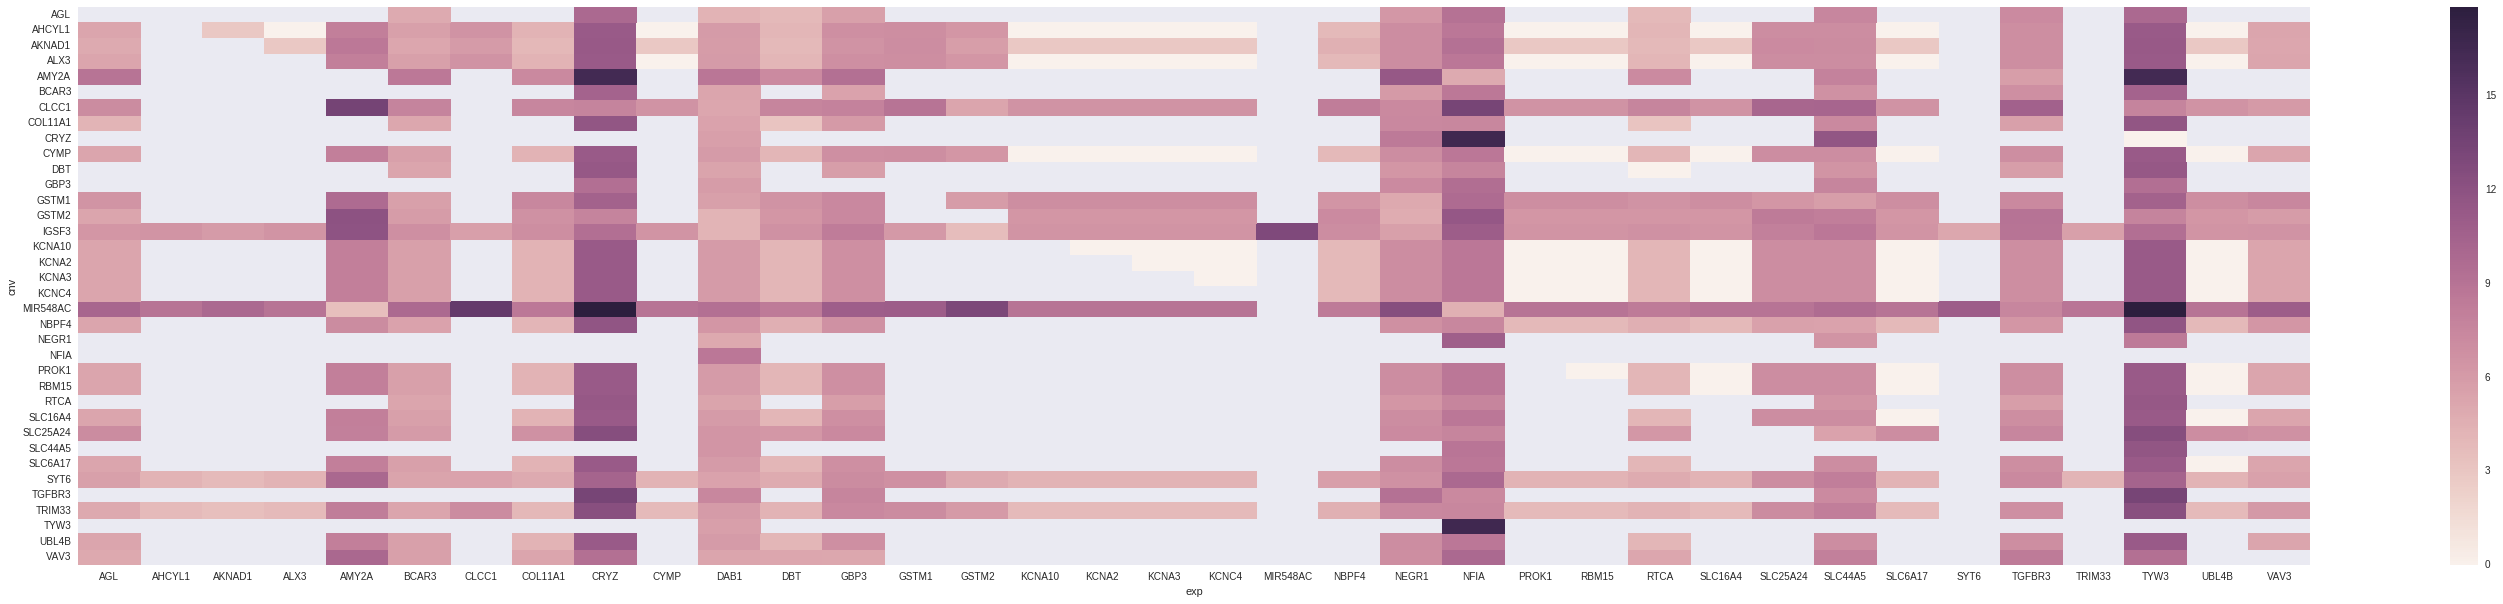

In [9]:
% matplotlib inline
matplotlib.rcParams['figure.figsize'] = (50.0, 10.0)
df_pear_piv = df_eucl_samp.pivot('cnv','exp','euclidian')

ax = sns.heatmap(df_pear_piv)

loosening up filter params: var=0.2 from 2, n=2 from 6

In [70]:
# get gene names on the 1p chromosome arm

chrloc = pd.read_csv('data/hugo_to_locus.txt', sep = '\t')
print(chrloc.shape)
chrloc.dropna(subset=['Chromosome'], inplace=True)
print(chrloc.shape)
chrloc = chrloc[chrloc['Chromosome'].str.startswith('1p')]
print(chrloc.shape)

#order them
chrloc.sort_values(by='Chromosome', inplace=True)
genes_1p = chrloc['Approved Symbol'].unique()

(45890, 6)
(41439, 6)
(2001, 6)


In [71]:
# data sources for CLOvE computation
edf = pd.read_csv('data/breast_mrna.tab.gz', compression='gzip', sep='\t', index_col=0)
cdf = pd.read_csv('data/breast_CCLE_DEL_calls.csv.gz', compression='gzip', index_col=0)

#filter data sources
edf_f, cdf_f = mainFitler(edf, cdf, var=0.5, n=5, amp_fh=False, dele_fh=False, mut_fh=False, save=False)

# array of bait genes on chr1
chr1 = pd.read_csv('data/breast_ttest_real_chr1_samp.tab.gz', sep='\t', compression='gzip', index_col=0)['cnv'].unique()

df = explicitPairContextStat(edf_f, cdf_f, cnv_lis=genes_1p)

PSORS7 not found in cnvdf.index.  Omitted
SAI1 not found in cnvdf.index.  Omitted
LINC01691 not found in cnvdf.index.  Omitted
NBPF26 not found in cnvdf.index.  Omitted
NBPF8 not found in cnvdf.index.  Omitted
FAM91A4P not found in cnvdf.index.  Omitted
NOTCH2NLR not found in cnvdf.index.  Omitted
EMBP1 not found in cnvdf.index.  Omitted
HIST2H2BA not found in cnvdf.index.  Omitted
MTIF2P1 not found in cnvdf.index.  Omitted
LINC00623 not found in cnvdf.index.  Omitted
SRGAP2C not found in cnvdf.index.  Omitted
FCGR1B not found in cnvdf.index.  Omitted
FAM72B not found in cnvdf.index.  Omitted
RNU6-465P not found in cnvdf.index.  Omitted
RPL22P6 not found in cnvdf.index.  Omitted
SRGAP2-AS1 not found in cnvdf.index.  Omitted
PPIAL4A not found in cnvdf.index.  Omitted
PFN1P2 not found in cnvdf.index.  Omitted
HIST2H3DP1 not found in cnvdf.index.  Omitted
PNRC2P1 not found in cnvdf.index.  Omitted
HMGCS2 not found in cnvdf.index.  Omitted
HAO2-IT1 not found in cnvdf.index.  Omitted
GAPDHP

In [35]:
df['cnv'].unique()

array(['IGSF3', 'MIR548AC', 'SYT6', 'TRIM33', 'AHCYL1', 'AKNAD1', 'ALX3',
       'CLCC1', 'CYMP', 'GSTM1', 'GSTM2', 'KCNA10', 'KCNA2', 'KCNA3',
       'KCNC4', 'NBPF4', 'PROK1', 'RBM15', 'SLC16A4', 'SLC25A24',
       'SLC6A17', 'UBL4B', 'VAV3', 'AMY2A', 'COL11A1', 'AGL', 'DBT',
       'RTCA', 'BCAR3', 'TGFBR3', 'GBP3', 'CRYZ', 'NEGR1', 'SLC44A5',
       'TYW3', 'NFIA', 'DAB1', 'OMA1', 'ACOT11', 'FAF1', 'GLIS1', 'SCP2',
       'FAM76A', 'FGR', 'IFI6', 'SMPDL3B', 'MDS2', 'ARID1A', 'CD164L2',
       'CD52', 'CLIC4', 'CNR2', 'DHDDS', 'FCN3', 'FUCA1', 'GALE',
       'GPATCH3', 'GPN2', 'GPR3', 'GRHL3', 'HMGCL', 'HMGN2', 'IL22RA1',
       'LIN28A', 'LYPLA2', 'MAP3K6', 'MIR1976', 'MIR378F', 'MYOM3',
       'NCMAP', 'NR0B2', 'NUDC', 'PIGV', 'PITHD1', 'PNRC2', 'RHCE', 'RHD',
       'RPS6KA1', 'RUNX3', 'SFN', 'SLC9A1', 'SRSF10', 'STPG1', 'SYF2',
       'SYTL1', 'TMEM222', 'TRNP1', 'UBXN11', 'WASF2', 'WDTC1', 'ZDHHC18',
       'ZNF683', 'AHDC1', 'ALPL', 'C1QA', 'C1QB', 'C1QC', 'CAMK2N1', 'CDA',
  

[]

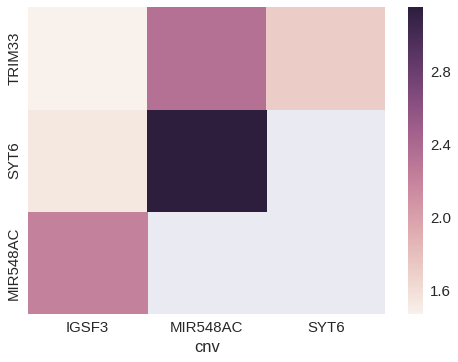

In [40]:
# BELOW IS EXAMPLE TO SORT PIVOT INDEX TO CHANGE THE ORDER OF X-AXIS BY CHR LOC
# try to order the heatmap axis
df_head = df[(df['cnv']=='IGSF3') | (df['cnv']=='MIR548AC') | (df['cnv']=='SYT6') | (df['cnv']=='TRIM33')]
df_head = df_head[(df_head['exp']=='AP1S2') | (df_head['exp']=='CD9') | (df_head['exp']=='CEBPD')]
df_head_eucl = rolling_similarity(df_head, how='euclidian')

% matplotlib inline
matplotlib.rcParams['figure.figsize'] = (50.0, 20.0)
sns.set(font_scale=1.5)
df_head_eucl_piv = df_head_eucl.pivot('exp','cnv','euclidian')

df_head_eucl_piv.index = pd.CategoricalIndex(df_head_eucl_piv.index, categories= df_head['cnv'].unique())
df_head_eucl_piv.sortlevel(level=0, ascending=False, inplace=True)


ax = sns.heatmap(df_head_eucl_piv)
ax.plot(label='large')

compute euclidian distance

In [42]:
df_eucl = rolling_similarity(df, how='euclidian')
df_eucl_piv = df_eucl.pivot('exp','cnv','euclidian')

df_eucl_piv.index = pd.CategoricalIndex(df_eucl_piv.index, categories= df['cnv'].unique())
df_eucl_piv.sortlevel(level=0, ascending=False, inplace=True)

In [66]:
# df_eucl_piv.to_csv('data/breast_ttest_euclid_piv.tab.gz', sep='\t', compression='gzip')
df_eucl_piv = pd.read_csv('data/breast_ttest_euclid_piv.tab.gz', sep='\t', compression='gzip', index_col=0)

In [67]:
df_eucl_piv.shape

(376, 376)

In [68]:
% matplotlib inline

df_eucl_piv.index = pd.CategoricalIndex(df_eucl_piv.index, categories= df['cnv'].unique())
df_eucl_piv.sortlevel(level=0, ascending=False, inplace=True)

df_eucl_piv.columns = pd.CategoricalIndex(df_eucl_piv.columns, categories= df['cnv'].unique())
df_eucl_piv.sortlevel(level=1, ascending=False, inplace=True)

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 15)
sns.set(font_scale=0.09)
sns.heatmap(df_eucl_piv, square=True)

# fig.savefig('breast_chr1_euclid_A4.png', dpi=1000)

NameError: name 'df' is not defined

compute pearson

In [8]:
# df_pear_piv.to_csv('data/breast_ttest_pear_piv.tab.gz', sep='\t', compression='gzip')
df_pear_piv = pd.read_csv('data/breast_ttest_pear_piv.tab.gz', sep='\t', compression='gzip', index_col=0)

In [9]:
# df_pear = rolling_similarity(df, how='pearson')
# df_pear_piv = df_pear.pivot('exp','cnv','pearson')

df_pear_piv.index = pd.CategoricalIndex(df_pear_piv.index, categories= df['cnv'].unique())
df_pear_piv.sortlevel(level=0, ascending=False, inplace=True)
df_pear_piv.columns = pd.CategoricalIndex(df_pear_piv.columns, categories= df['cnv'].unique())
df_pear_piv.sortlevel(level=1, ascending=False, inplace=True)

AttributeError: 'Figure' object has no attribute 'get_legend'

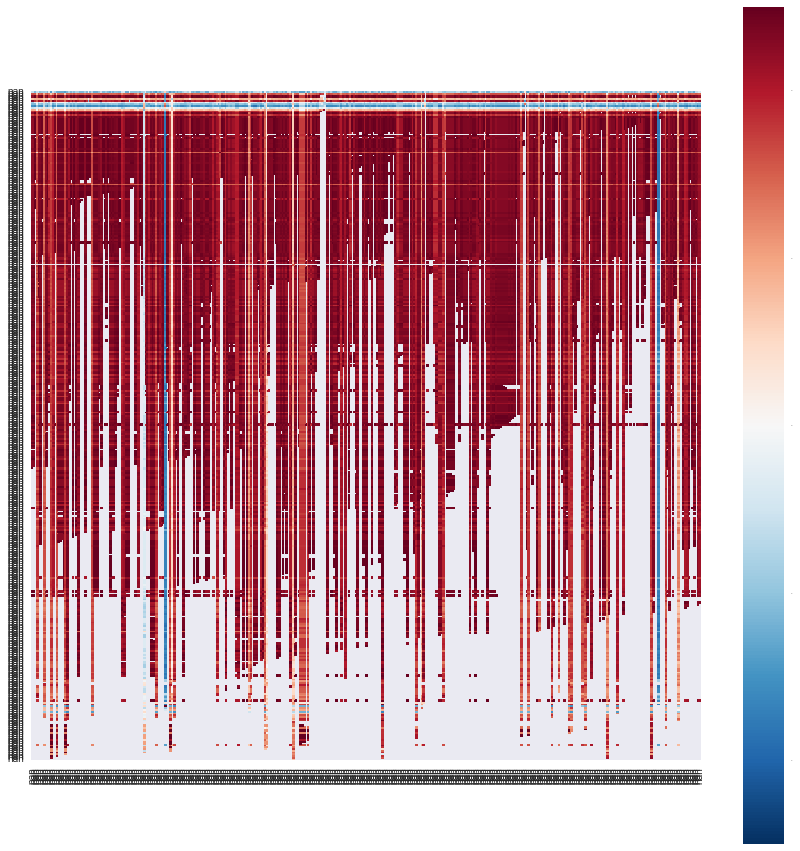

In [10]:
% matplotlib inline

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 15)
sns.set(font_scale=0.09)
sns.heatmap(df_pear_piv, square=True)
plt.setp(fig.get_legend().get_texts(), fontsize='22')

# fig.savefig('breast_chr1_pear_A4.png', dpi=1000)

#### Vizeacoumar (Viz) dataset has scores by 5 deprivation contexts (BLM, MUS81, PTEN, PWT, PTTG1) and WT, all but WT are represented sufficiently in the CLOvE dataset 


In [11]:
viz_bait = ['PTTG1', 'BLM','MUS81', 'PTEN', 'KRAS']

In [4]:
df = pd.read_csv('data/all_ttest_real_viz.tab.gz', sep='\t', compression='gzip', index_col=0)

In [12]:
expdf = pd.read_csv('data/all_mrna.tab.gz', sep='\t', compression='gzip', index_col=0)
cnvdf = pd.read_pickle('data/CCLE_DEL_calls_viz.pickle')

In [13]:
df_null = randomPairContextStat(1000000, expdf, cnvdf, permute=True)

In [16]:
df_null.to_csv('data/all_ttest_real_null_viz.tab.gz', sep='\t', compression='gzip')

In [21]:
df_null = map_locus(df_null)
df_null.head()


,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,np_t_w_null,t_shrnk_glob,gene_var_exp,chromosome
171605,LIN7C,PTEN,101,895,8.776710,8.837844,0.171250,0.268885,-0.120009,-1.14329,0.253192,0.933199,-0.534734,0.259585,10q23.31
167792,AURKA,PTEN,101,895,10.677295,10.608785,0.361709,0.525072,0.095978,0.914357,0.360751,-0.959141,0.554914,0.509446,10q23.31
167793,AURKA,PTEN,101,895,10.677295,10.608785,0.361709,0.525072,0.095978,0.914357,0.360751,-0.959141,0.554914,0.509446,10q23.31
167794,AURKA,PTEN,101,895,10.677295,10.608785,0.361709,0.525072,0.095978,0.914357,0.360751,-0.959141,0.554914,0.509446,10q23.31
167795,AURKA,PTEN,101,895,10.677295,10.608785,0.361709,0.525072,0.095978,0.914357,0.360751,-0.959141,0.554914,0.509446,10q23.31


In [65]:
viz = pd.read_csv('data/viz_HCT116_GARP-score.txt.tar.gz', sep='\t', compression='gzip', index_col=0)

In [67]:
viz = viz[['Gene Name','Description','HCT116_BLM','HCT116_MUS81','HCT116_PTEN','HCT116_PWT','HCT116_PTTG1','HCT116_WT']]
viz

,Gene Name,Description,HCT116_BLM,HCT116_MUS81,HCT116_PTEN,HCT116_PWT,HCT116_PTTG1,HCT116_WT
HCT116_GARP-score.txt,,,,,,,,
NM_018117,WDR11,WD repeat domain 11,-0.156363,-0.306122,-0.357102,-0.084159,-0.413263,-0.121228
NM_001004460,OR10A2,"olfactory receptor, family 10, subfamily A, me...",-0.055357,-0.109505,-0.077226,-0.070077,-0.127857,-0.059772
NM_021107,MRPS12,mitochondrial ribosomal protein S12,-0.111989,-0.059505,-0.184910,-0.066028,-0.217499,-0.039225
NM_173803,MPV17L,MPV17 mitochondrial membrane protein-like,-0.036167,-0.148610,-0.225790,-0.068753,-0.239617,-0.051944
NM_006528,TFPI2,tissue factor pathway inhibitor 2,-0.180304,-0.315834,-0.387426,-0.190001,-0.292052,-0.091514
NM_018283,NUDT15,nudix (nucleoside diphosphate linked moiety X)...,-0.019991,-0.096132,-0.135179,-0.073432,-0.187830,-0.051562
NM_017722,TRMT1,TRM1 tRNA methyltransferase 1 homolog (S. cere...,-0.319461,-0.101908,-0.093429,-0.118008,-0.220807,-0.064457
NM_006228,PNOC,prepronociceptin,0.019299,-0.086702,-0.001842,-0.071489,-0.029707,-0.009812
NM_006495,EVI2B,ecotropic viral integration site 2B,-0.018433,-0.155776,-0.078900,-0.057902,-0.229445,-0.065921


In [99]:
def get_viz_pearson(viz_df, clove_df, bait_gene, wt=False, graph=True):
    """
    just used to get a correlation between viz GARP scores with cloves of your choosing 
    """
    %matplotlib inline
    for col in viz_df.columns:
        if bait_gene in col:
            bait_df = viz_df[['Gene Name', 'Description', col]]
            break
    bait_df['cnv'] = bait_gene
    bait_df.reset_index(drop=True, inplace=True)
    bait_df.columns = ['exp','exp_desc','garp','cnv']
    
    clove_df = clove_df[clove_df['cnv']==bait_gene].drop_duplicates()
    merged_df =  clove_df.merge(bait_df, on='exp', how='inner')
    
    print(stats.pearsonr(merged_df['np_t_w'], merged_df['garp']))
    
    if graph:
        sns.set(font_scale=1)
        sns.jointplot(x='np_t_w', y='garp', data=merged_df)
        print('Clove vs GARP score in {}-/-'.format(bait_gene))
        

(0.0099634624793492801, 0.60075977348663456)
Clove vs GARP score in BLM-/-


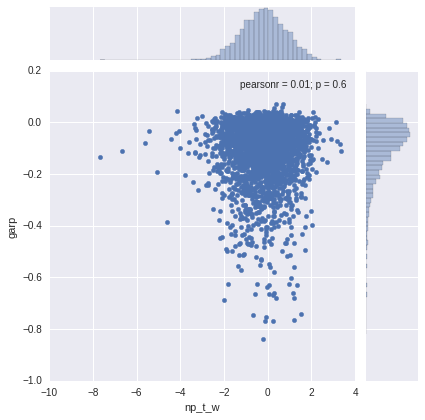

In [100]:
get_viz_pearson(viz, df_null, 'BLM')

(-0.034627575806663327, 0.068875559706891618)
Clove vs GARP score in PTTG1-/-


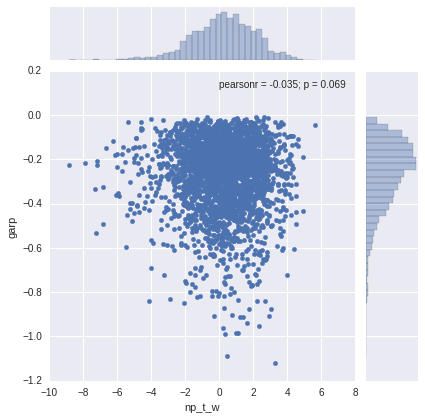

In [101]:
get_viz_pearson(viz, df_null, 'PTTG1')

(0.025749402503406349, 0.17617720020274899)
Clove vs GARP score in MUS81-/-


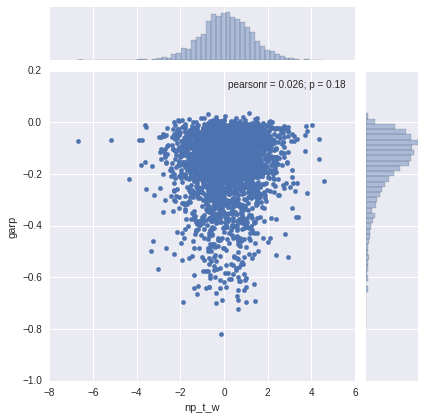

In [102]:
get_viz_pearson(viz, df_null,  'MUS81')

(0.024229771191375381, 0.20310004449375446)
Clove vs GARP score in PTEN-/-


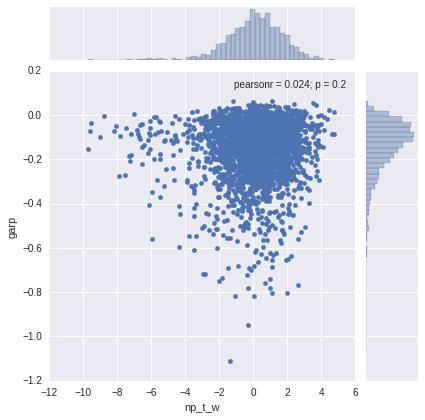

In [103]:
get_viz_pearson(viz, df_null, 'PTEN')

### compute the KS between Clove and Null for all tissues and graph it as a barblot

In [93]:
done = ['haematopoietic_and_lymphoid_tissue',
'lung',
'autonomic_ganglia',
'kidney',
'pancreas',
'central_nervous_system',
'oesophagus',
'breast',
'biliary_tract',
'ovary',
'prostate',
'large_intestine',
       'salivary_gland']

for filename in os.listdir('data_large/tissue_df_raw/'):
    if filename.endswith('mrna_df.pickle'): 
        # data sources for CLOvE computation
        tissue = filename.split('_mrna')[0]
        if tissue not in done:
            print(tissue)
            

liver
urinary_tract
pleura
bone
thyroid
soft_tissue
skin
stomach
small_intestine
endometrium
upper_aerodigestive_tract


In [94]:
cdf = pd.read_pickle('data_large/CCLE_DEL_calls.pickle')
for filename in os.listdir('data_large/tissue_df_raw/'):
    if filename.endswith('mrna_df.pickle') and filename: 
        # data sources for CLOvE computation
        tissue = filename.split('_mrna')[0]
        
        if tissue not in done:
            print('working on:    ', tissue)
            edf = pd.read_pickle('data_large/tissue_df_raw/'+filename)

            edf_f, cdf_f = mainFitler(edf, cdf, var=0.5, n=2, amp_fh=False, dele_fh=False, mut_fh=False, save=False)
            
            if edf_f.shape[0] != 0 and cdf_f.shape[0] != 0:  #salivary glad only had two cell lines
                clove_df = randomPairContextStat(100000, edf_f, cdf_f, permute=True, nan_style='propagate')
                clove_df['tissue'] = tissue
                clove_df.to_csv('data_large/tissue_df_clove_samp100k/'+tissue+'.tab.gz', sep='\t', compression='gzip')
            else:
                print("insufficent samples in:  "+tissue, edf_f.shape, cdf_f.shape)

working on:     liver
working on:     urinary_tract
working on:     pleura
working on:     bone
working on:     thyroid
working on:     soft_tissue
working on:     skin
working on:     stomach
working on:     small_intestine
insufficent samples in:  small_intestine (0, 1) (23228, 1030)
working on:     endometrium
working on:     upper_aerodigestive_tract


In [96]:
salv = pd.read_pickle('data_large/tissue_df_raw/salivary_gland_mrna_df.pickle')
if salv.shape[1]<=2:
    print("insufficent samples in:  "+'salivary_gland', salv.shape)

insufficent samples in:  salivary_gland (11426, 2)


In [82]:
False in boolist

True

In [105]:
df_merge = pd.DataFrame()
for filename in os.listdir('data/tissue_df_clove_samp100k/'):
    if filename.endswith('.tab.gz') and filename: 
        # data sources for CLOvE computation
        tissue = filename.split('.tab.gz')[0]
        df_100k = pd.read_csv('data/tissue_df_clove_samp100k/'+filename, sep='\t', compression='gzip', index_col=0)
        df_merge = pd.concat([df_merge, df_100k])
df_merge.to_csv('data/tissue_df_clove_samp100k/all_cells_merged_samp100k.tab.gz', sep='\t', compression='gzip')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151213 entries, 0 to 3642
Data columns (total 15 columns):
exp             151213 non-null object
cnv             151213 non-null object
pos_n           151213 non-null int64
neg_n           151213 non-null int64
pos_mu          151213 non-null float64
neg_mu          151213 non-null float64
pos_var         151213 non-null float64
neg_var         151213 non-null float64
cohens_d        151213 non-null float64
np_t_w          151213 non-null float64
np_p_w          151213 non-null float64
np_t_w_null     151213 non-null float64
t_shrnk_glob    151213 non-null float64
gene_var_exp    151213 non-null float64
tissue          151213 non-null object
dtypes: float64(10), int64(2), object(3)
memory usage: 18.5+ MB


In [106]:
df_merge

,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,np_t_w_null,t_shrnk_glob,gene_var_exp,tissue
0,RBCK1,CABIN1,2,8,7.901011,7.297110,0.827816,0.485090,0.725937,0.918246,0.385338,1.489108,0.479042,0.679985,thyroid
1,RBCK1,CNTN6,3,7,6.909248,7.635879,0.205550,0.627776,-0.918108,-1.330464,0.220039,-0.904557,-0.723929,0.679985,thyroid
2,RPUSD4,MIAT,2,8,9.559928,8.558124,0.304882,0.746036,1.104788,1.397459,0.199814,-0.408628,0.858921,0.909315,thyroid
3,NSMCE2,SNORD125,2,8,8.861842,9.292331,0.205841,0.725956,-0.488241,-0.617582,0.554019,-0.058403,-0.376357,0.723982,thyroid
4,NSMCE2,INPP5J,2,8,8.861842,9.292331,0.205841,0.725956,-0.488241,-0.617582,0.554019,-0.058403,-0.376357,0.723982,thyroid
5,FAM54A,FUCA1,2,8,8.365197,7.874599,1.121340,1.799305,0.340198,0.430320,0.678320,-1.871422,0.355892,1.891358,thyroid
6,FAM54A,MMP11,2,8,7.176207,8.171847,5.053162,0.666227,-0.716767,-0.906647,0.391084,-2.860373,-0.515901,1.891358,thyroid
7,USP4,PRAMEF9,2,8,8.191859,8.854437,0.054404,0.723304,-0.771847,-0.976317,0.357502,0.292532,-0.596869,0.733073,thyroid
8,USP4,AUNIP,2,8,8.191859,8.854437,0.054404,0.723304,-0.771847,-0.976317,0.357502,0.292532,-0.596869,0.733073,thyroid
9,USP4,IFNA2,2,8,8.191859,8.854437,0.054404,0.723304,-0.771847,-0.976317,0.357502,0.292532,-0.596869,0.733073,thyroid


In [140]:
lis_big = []
for tissue in df_merge['tissue'].unique():
    tissue=tissue.strip()
    temp_df = df_merge[df_merge['tissue']==tissue]
    ks = stats.ks_2samp(temp_df['np_t_w'], temp_df['np_t_w_null'])
    tt = stats.ttest_ind(temp_df['np_t_w'], temp_df['np_t_w_null'])
    lis_big.append([tissue, ks[0], ks[1], tt[0], tt[1]])
null_sep = pd.DataFrame(lis_big, columns=['tissue','ks_d','ks_p','tt_s','tt_p'])

null_sep['ks_p_log'] = -1*np.log10(null_sep['ks_p'])
null_sep['tt_p_log'] = -1*np.log10(null_sep['tt_p'])

In [141]:
null_sep.sort_values(by='ks_p_log', ascending=False).head()

,tissue,ks_d,ks_p,tt_s,tt_p,ks_p_log,tt_p_log
18,breast,0.086799,4.887888e-43,14.452150,3.704651e-47,42.310879,46.431253
1,bone,0.117723,1.385349e-28,8.356274,7.401368e-17,27.858441,16.130688
2,kidney,0.072122,1.646222e-27,10.322190,6.310147e-25,26.783511,24.199961
10,autonomic_ganglia,0.047619,1.826466e-07,-6.427317,1.340110e-10,6.738388,9.872859
12,biliary_tract,0.082413,7.020061e-07,-4.260132,2.086331e-05,6.153659,4.680617


In [142]:
# notice taht bone and kidney swap places in tt vs ks comparison
null_sep.sort_values(by='tt_p_log', ascending=False).head()

,tissue,ks_d,ks_p,tt_s,tt_p,ks_p_log,tt_p_log
18,breast,0.086799,4.887888e-43,14.452150,3.704651e-47,42.310879,46.431253
2,kidney,0.072122,1.646222e-27,10.322190,6.310147e-25,26.783511,24.199961
1,bone,0.117723,1.385349e-28,8.356274,7.401368e-17,27.858441,16.130688
10,autonomic_ganglia,0.047619,1.826466e-07,-6.427317,1.340110e-10,6.738388,9.872859
9,upper_aerodigestive_tract,0.032180,5.462733e-04,5.099895,3.437778e-07,3.262590,6.463722


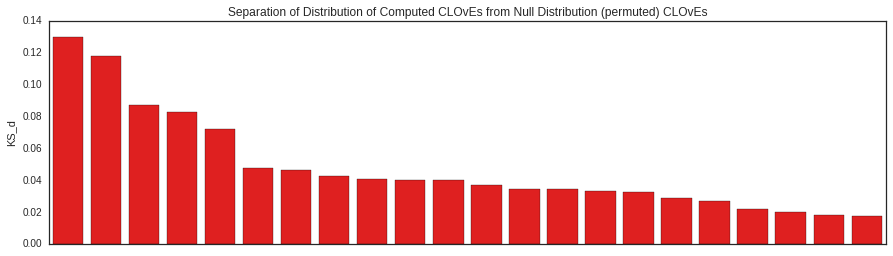

In [160]:
%matplotlib inline
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 4)
sort_df = null_sep.sort_values(by='ks_d', ascending=False)
ax = sns.barplot(data=sort_df, x='tissue', y='ks_d', color='red')
ax.set_xticklabels(labels=[] ,rotation=90)
plt.title('Separation of Distribution of Computed CLOvEs from Null Distribution (permuted) CLOvEs')
plt.ylabel('KS_d')
plt.xlabel('')


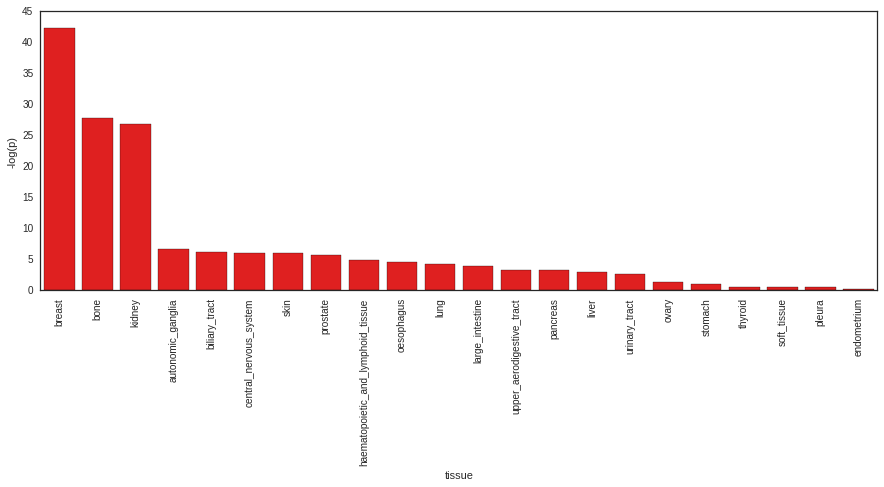

In [161]:
%matplotlib inline
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 5)
sort_df = null_sep.sort_values(by='ks_p_log', ascending=False)
ax = sns.barplot(data=sort_df, x='tissue', y='ks_p_log', color='red')
ax.set_xticklabels(labels=sort_df['tissue'] ,rotation=90)
# plt.title('Separation of Distribution of Computed CLOvEs from Null Distribution (permuted) CLOvEs, KS')
plt.ylabel('-log(p)')


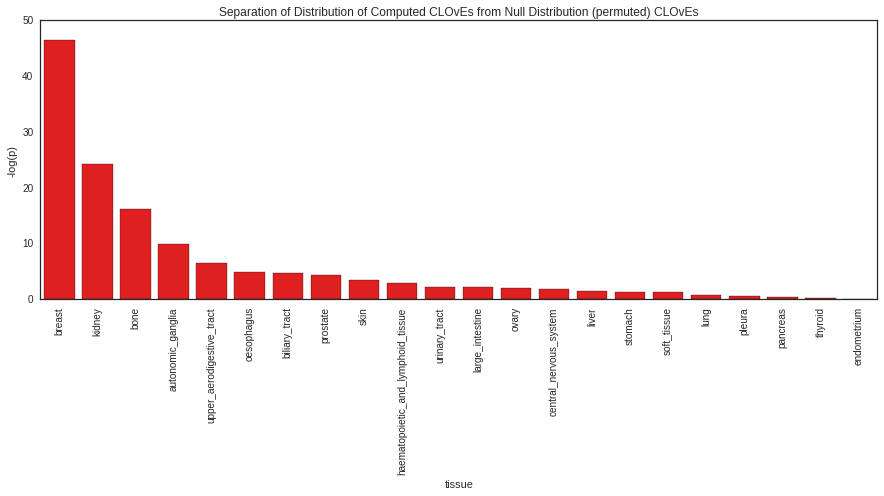

In [150]:
%matplotlib inline
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 5)
sort_df = null_sep.sort_values(by='tt_p_log', ascending=False)
ax = sns.barplot(data=sort_df, x='tissue', y='tt_p_log', color='red')
ax.set_xticklabels(labels=sort_df['tissue'] ,rotation=90)
plt.title('Separation of Distribution of Computed CLOvEs from Null Distribution (permuted) CLOvEs')
plt.ylabel('-log(p)')